<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#개요" data-toc-modified-id="개요-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>개요</a></span><ul class="toc-item"><li><span><a href="#주제:-Allstate-Claims-Severity" data-toc-modified-id="주제:-Allstate-Claims-Severity-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>주제: Allstate Claims Severity</a></span></li><li><span><a href="#데이터-설명" data-toc-modified-id="데이터-설명-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>데이터 설명</a></span></li><li><span><a href="#함수-설정" data-toc-modified-id="함수-설정-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>함수 설정</a></span></li></ul></li><li><span><a href="#탐색적-분석(시각화-및-전처리)" data-toc-modified-id="탐색적-분석(시각화-및-전처리)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>탐색적 분석(시각화 및 전처리)</a></span><ul class="toc-item"><li><span><a href="#cont변수-시각화-및-전처리" data-toc-modified-id="cont변수-시각화-및-전처리-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>cont변수 시각화 및 전처리</a></span><ul class="toc-item"><li><span><a href="#선형회귀모델-p-value,-VIF-확인" data-toc-modified-id="선형회귀모델-p-value,-VIF-확인-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>선형회귀모델 p-value, VIF 확인</a></span></li></ul></li><li><span><a href="#cat변수-시각화-및-전처리" data-toc-modified-id="cat변수-시각화-및-전처리-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>cat변수 시각화 및 전처리</a></span><ul class="toc-item"><li><span><a href="#cat변수-시각화" data-toc-modified-id="cat변수-시각화-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>cat변수 시각화</a></span></li><li><span><a href="#cat변수와-loss의-유의성(평균-차이)-검정" data-toc-modified-id="cat변수와-loss의-유의성(평균-차이)-검정-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>cat변수와 loss의 유의성(평균 차이) 검정</a></span></li><li><span><a href="#(변수내)-범주간-loss평균차에-따른-검정" data-toc-modified-id="(변수내)-범주간-loss평균차에-따른-검정-2.2.3"><span class="toc-item-num">2.2.3&nbsp;&nbsp;</span>(변수내) 범주간 loss평균차에 따른 검정</a></span></li></ul></li><li><span><a href="#loss-시각화" data-toc-modified-id="loss-시각화-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>loss 시각화</a></span></li></ul></li><li><span><a href="#데이터-전처리" data-toc-modified-id="데이터-전처리-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>데이터 전처리</a></span></li><li><span><a href="#딥러닝-모델" data-toc-modified-id="딥러닝-모델-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>딥러닝 모델</a></span><ul class="toc-item"><li><span><a href="#예측-및-결과-평가-(test-MAE-계산)" data-toc-modified-id="예측-및-결과-평가-(test-MAE-계산)-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>예측 및 결과 평가 (test MAE 계산)</a></span></li></ul></li></ul></div>

# 개요
## 주제: Allstate Claims Severity
https://www.kaggle.com/c/allstate-claims-severity<br>
보험금 청구비용(loss) 예측 모델을 구축한다.

## 데이터 설명
미국의 개인 보험 회사 Allstate 계약(id)별 보험금 청구액(loss)관련 자료이다.<br>
컬럼명 cat1,2,3... cont1,2,3... 은 아래와 같이 의미한다.<br>
'cat' - categorical(명목형 변수)<br>
'cont' - continuous (연속형 변수)<br>

cat 데이터는 A,B,C...., LB,DC,CQ...등 유형을 나타내도록 변환되었고, cont 데이터는 0~1 소숫점으로 변환되어 주어진 상태이다.<br>
***변수가 익명화 되어 있어 변수 의미에 따른 분석 불가***

In [6]:
 # !pip install xgboost
import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as st

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, NMF
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.preprocessing import scale, robust_scale, minmax_scale, maxabs_scale

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

## 함수 설정

In [2]:
# Kmeans 관련 함수 설정

# kmeans로 확인 후 cont변수와 합쳐주는 DF 생성 함수
def kmeans_united(n, df) :
    # Kmenas로 변환
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(df)
    res = pd.Series(kmeans.labels_)
    tmp_X = pd.get_dummies(res, prefix="kmeans")
    
    # 기존 cont데이터와 병합
    new_X = pd.concat([tmp_X, X[cont_columns]], axis=1)
    
    return new_X

# kmeans Elbow 시각화
def kmeans_Elbow(df):
    cluster_range = range( 1, 20 )
    cluster_errors = []

    for num_clusters in cluster_range:
      clusters = KMeans( num_clusters )
      clusters.fit( df )
      cluster_errors.append( clusters.inertia_ )

    clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )

    # Kmeans cluster_errors의 최적화 시각화
    plt.figure(figsize=(12,6), )
    plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o", )
    plt.title("The Elbow Method showing the optimal k")
    plt.show()
    
# kmeans 실행(클러스터 갯수 3,5,10,15,20,25 결과값 출력)
def kmeans_run(df) :
    reg_train_result = []
    reg_test_result = []
    kmeans_n = []
    for cluster in [3,5,10,15,20,30,40]:
        # Kmeans 실행
        X_kmeans = kmeans_united(cluster, df) 

        # 회귀분석 실행
        X_train, X_test, Y_train, Y_test = train_test_split(X_kmeans, y, test_size=0.3, random_state=5) 
        lm = LinearRegression()
        lm.fit(X_train,Y_train)
        Y_pred_train = lm.predict(X_train)
        Y_pred_test = lm.predict(X_test)

        # 결과저장
        kmeans_n.append(f'Kmeans_{cluster}')
        reg_train_result.append(str(metrics.mean_absolute_error(Y_train, Y_pred_train)))
        reg_test_result.append(str(metrics.mean_absolute_error(Y_test, Y_pred_test)))
    
    list_result = list(zip(kmeans_n, reg_train_result, reg_test_result))
    result = pd.DataFrame(list_result, columns = ['kmeans_n', 'reg_train_result','reg_test_result'])
    print(result)

In [3]:
# PCA 관련 함수 설정

# pca로 차원축소 후 cont변수와 합쳐주는 DF 생성 함수
def pca_united(n, df) :
    # pca로 변환
    pca = PCA(n_components = n)
    X_pca = pca.fit_transform(df)
    
    # 기존 cont데이터와 병합
    new_X = pd.concat([pd.DataFrame(X_pca), X[cont_columns]], axis=1)
    
    return new_X

# pca 실행(주성분 갯수 3,5,10,15,20,25,30,35,40,45,50 결과값 출력)
def pca_run(df) :
    reg_train_result = []
    reg_test_result = []
    pca_n = []
    for cluster in [3,5,10,15,20,25,30,35,40,45,50]:
        # Kmeans 실행
        X_pca = pca_united(cluster, df) 

        # 회귀분석 실행
        X_train, X_test, Y_train, Y_test = train_test_split(X_pca, y, test_size=0.3, random_state=5) 
        lm = LinearRegression()
        lm.fit(X_train,Y_train)
        Y_pred_train = lm.predict(X_train)
        Y_pred_test = lm.predict(X_test)

        # 결과저장
        pca_n.append(f'pca_{cluster}')
        reg_train_result.append(str(metrics.mean_absolute_error(Y_train, Y_pred_train)))
        reg_test_result.append(str(metrics.mean_absolute_error(Y_test, Y_pred_test)))

    list_result = list(zip(pca_n, reg_train_result, reg_test_result))
    result = pd.DataFrame(list_result, columns = ['pca_n', 'reg_train_result','reg_test_result'])
    print(result)

In [4]:
# stats 모듈 선형회귀 관련 함수

# 선형회귀모델 summary와 FMSE 출력
def st_Reg(X_train, X_test, Y_train, Y_test) :
    X_train = sm.add_constant(X_train) # 상수항 생성
    
    # 모델 학습
    model = sm.OLS(Y_train, X_train).fit()
    print_model = model.summary()
    X_test = sm.add_constant(X_test)
    
    # 회귀모형 predict
    predictions = model.predict(X_test)
    rmse = sm.tools.eval_measures.rmse(predictions, Y_test, axis=0)
    
    # 다중공선성 검정(vif)
    tmp_vif = pd.DataFrame()
    tmp_vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
    tmp_vif = tmp_vif.T
    tmp_vif.columns = X_train.columns
    
    print(print_model)
    print('---------------------------------------------------------------------------------')
    print(f'RMSE : {rmse}')
    print('---------------------------------------------------------------------------------')
    print(tmp_vif)

In [5]:
# 범주간 평균차가(예:A의 loss평균 - B의 loss평균) n이상인 변수명을 리스트로 반환
def maxMinusMin(n,df) :
    maxMinusMinList = []
    for col in df.drop(columns='loss').columns :
        tmpMax = max(X_cat[col])
        tmpMin = min(X_cat[col])

        if tmpMax - tmpMin > n :
            maxMinusMinList.append(col)
            #print(f'{col}의 최대값-최소값 : {tmpMax - tmpMin}')
        #else :
            #print(f'{col}의 최대값-최소값 : {tmpMax - tmpMin} <- 변수 삭제')
    return maxMinusMinList


# 탐색적 분석(시각화 및 전처리)

In [19]:
train = pd.read_csv('data/train.csv')
train.shape

(188318, 132)

In [20]:
X = train.iloc[:,1:-1]
y = train.loss

# X, X_validation, y, y_validation = train_test_split(X, y, test_size=0.3, random_state=5)

# # index 초기화
# X = X.reset_index().drop(columns='index')
# y = y.reset_index().drop(columns='index')
# X_validation = X_validation.reset_index().drop(columns='index')
# y_validation = y_validation.reset_index().drop(columns='index')

# cout와 cat 변수명 리스트로 담기
cont_columns = []
cat_columns = []

for i in X.columns:
    if X[i].dtype == 'float':
        cont_columns.append(i)
    elif X[i].dtype == 'object':
        cat_columns.append(i)
        
X_cont = X[cont_columns]
X_cat = X[cat_columns]

In [21]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Columns: 130 entries, cat1 to cont14
dtypes: float64(14), object(116)
memory usage: 186.8+ MB


In [22]:
X.head()

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cat19,cat20,cat21,cat22,cat23,cat24,cat25,cat26,cat27,cat28,cat29,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39,cat40,cat41,cat42,cat43,cat44,cat45,cat46,cat47,cat48,cat49,cat50,cat51,cat52,cat53,cat54,cat55,cat56,cat57,cat58,cat59,cat60,cat61,cat62,cat63,cat64,cat65,cat66,cat67,cat68,cat69,cat70,cat71,cat72,cat73,cat74,cat75,cat76,cat77,cat78,cat79,cat80,cat81,cat82,cat83,cat84,cat85,cat86,cat87,cat88,cat89,cat90,cat91,cat92,cat93,cat94,cat95,cat96,cat97,cat98,cat99,cat100,cat101,cat102,cat103,cat104,cat105,cat106,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,A,B,A,B,A,A,A,A,B,A,B,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,D,B,B,D,D,B,D,C,B,D,B,A,A,A,A,A,D,B,C,E,A,C,T,B,G,A,A,I,E,G,J,G,BU,BC,C,AS,S,A,O,LB,0.726300,0.245921,0.187583,0.789639,0.310061,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843
1,A,B,A,A,A,A,A,A,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,D,B,B,D,D,A,B,C,B,D,B,A,A,A,A,A,D,D,C,E,E,D,T,L,F,A,A,E,E,I,K,K,BI,CQ,A,AV,BM,A,O,DP,0.330514,0.737068,0.592681,0.614134,0.885834,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496
2,A,B,A,A,B,A,A,A,B,B,B,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,D,B,B,B,D,B,D,C,B,B,B,A,A,A,A,A,D,D,C,E,E,A,D,L,O,A,B,E,F,H,F,A,AB,DK,A,C,AF,A,I,GK,0.261841,0.358319,0.484196,0.236924,0.397069,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425
3,B,B,A,B,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,D,B,B,D,D,D,B,C,B,D,B,A,A,A,A,A,D,D,C,E,E,D,T,I,D,A,A,E,E,I,K,K,BI,CS,C,N,AE,A,O,DJ,0.321594,0.555782,0.527991,0.373816,0.422268,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642
4,A,B,A,B,A,A,A,A,B,B,A,B,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,D,B,D,B,D,B,B,C,B,B,C,A,A,A,B,H,D,B,D,E,E,A,P,F,J,A,A,D,E,K,G,B,H,C,C,Y,BM,A,K,CK,0.273204,0.159990,0.527991,0.473202,0.704268,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606


In [23]:
X.describe(include = ['object'])

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cat19,cat20,cat21,cat22,cat23,cat24,cat25,cat26,cat27,cat28,cat29,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39,cat40,cat41,cat42,cat43,cat44,cat45,cat46,cat47,cat48,cat49,cat50,cat51,cat52,cat53,cat54,cat55,cat56,cat57,cat58,cat59,cat60,cat61,cat62,cat63,cat64,cat65,cat66,cat67,cat68,cat69,cat70,cat71,cat72,cat73,cat74,cat75,cat76,cat77,cat78,cat79,cat80,cat81,cat82,cat83,cat84,cat85,cat86,cat87,cat88,cat89,cat90,cat91,cat92,cat93,cat94,cat95,cat96,cat97,cat98,cat99,cat100,cat101,cat102,cat103,cat104,cat105,cat106,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116
count,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318
unique,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,4,4,4,4,4,4,4,4,4,4,4,4,8,7,8,7,5,7,5,8,7,5,16,15,19,9,13,17,20,17,20,11,84,131,16,51,61,19,23,326
top,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,D,B,B,D,D,B,B,C,B,B,B,A,A,A,A,A,D,D,C,E,C,A,P,F,A,A,A,E,E,G,F,B,BI,CL,A,E,BM,A,K,HK
freq,141550,106721,177993,128395,123737,131693,183744,177274,113122,160213,168186,159825,168851,186041,188284,181843,187009,187331,186510,188114,187905,188275,157445,181977,169969,177119,168250,180938,184593,184760,182980,187107,187361,187734,188105,156313,165729,169323,183393,180119,181177,186623,184110,172716,183991,187436,187617,188049,179127,137611,187071,179505,172949,183762,188173,188136,185296,188079,188018,187872,187596,188273,188239,188271,186056,179982,187626,188176,188011,188295,178646,118322,154275,184731,154307,181347,187503,186526,152929,137505,154385,147536,141534,154939,186005,103852,166992,168926,183744,177993,111028,124689,150237,121642,87531,174360,78127,105492,79455,42970,106721,177274,123737,42925,76493,47165,47310,65512,152918,25305,128395,25148,26191,131693,43866,21061


In [24]:
X.describe()

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
count,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000
mean,0.493861,0.507188,0.498918,0.491812,0.487428,0.490945,0.484970,0.486437,0.485506,0.498066,0.493511,0.493150,0.493138,0.495717
std,0.187640,0.207202,0.202105,0.211292,0.209027,0.205273,0.178450,0.199370,0.181660,0.185877,0.209737,0.209427,0.212777,0.222488
min,0.000016,0.001149,0.002634,0.176921,0.281143,0.012683,0.069503,0.236880,0.000080,0.000000,0.035321,0.036232,0.000228,0.179722
25%,0.346090,0.358319,0.336963,0.327354,0.281143,0.336105,0.350175,0.312800,0.358970,0.364580,0.310961,0.311661,0.315758,0.294610
50%,0.475784,0.555782,0.527991,0.452887,0.422268,0.440945,0.438285,0.441060,0.441450,0.461190,0.457203,0.462286,0.363547,0.407403
75%,0.623912,0.681761,0.634224,0.652072,0.643315,0.655021,0.591045,0.623580,0.566820,0.614590,0.678924,0.675759,0.689974,0.724623
max,0.984975,0.862654,0.944251,0.954297,0.983674,0.997162,1.000000,0.980200,0.995400,0.994980,0.998742,0.998484,0.988494,0.844848


## cont변수 시각화 및 전처리

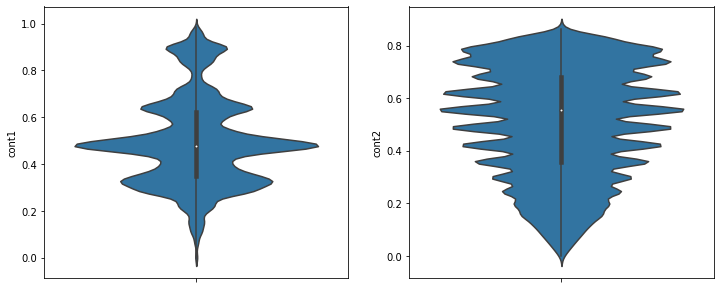

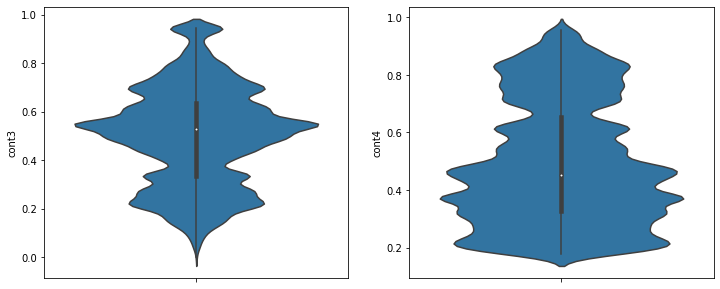

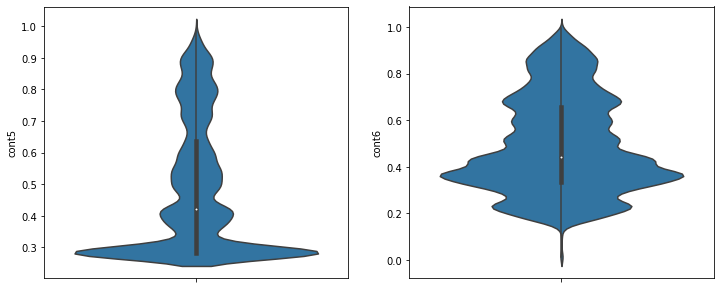

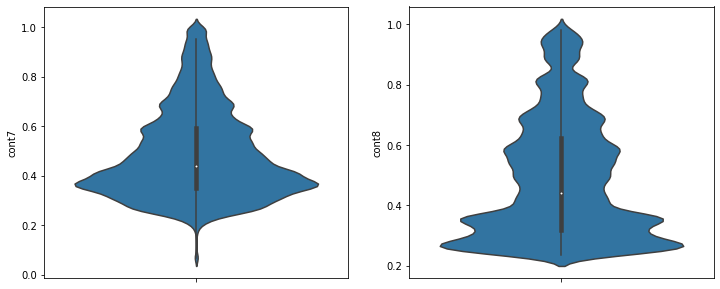

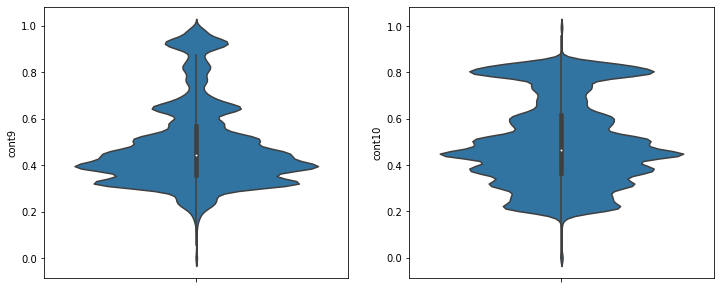

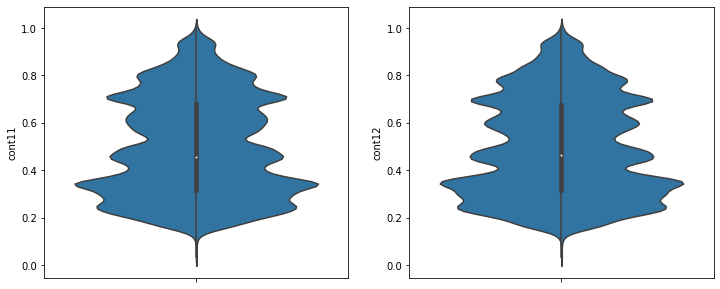

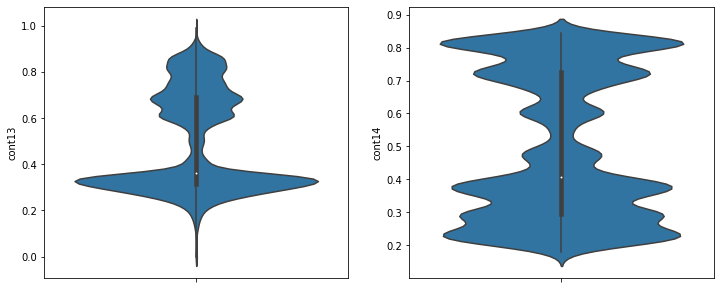

In [14]:
cols=X[cont_columns].columns 
n_cols = 2
n_rows = 7

for i in range(n_rows):
    fg,ax = plt.subplots(nrows=1,ncols=n_cols,figsize=(12, 5))
    for j in range(n_cols):
        sns.violinplot(cols[i*n_cols+j], data=X, ax=ax[j], orient='v')

In [15]:
round(X[cont_columns].corr(),2).style.background_gradient(cmap='coolwarm')

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
cont1,1,-0.09,-0.45,0.37,-0.03,0.76,0.37,0.36,0.93,0.81,0.59,0.61,0.54,0.06
cont2,-0.09,1,0.46,0.04,0.19,0.02,0.05,0.14,-0.03,0.06,0.12,0.11,0.02,-0.04
cont3,-0.45,0.46,1,-0.34,0.09,-0.35,0.1,-0.19,-0.42,-0.33,0.03,0.01,-0.42,-0.04
cont4,0.37,0.04,-0.34,1,0.16,0.22,-0.11,0.53,0.33,0.28,0.12,0.13,0.18,0.02
cont5,-0.03,0.19,0.09,0.16,1,-0.15,-0.25,0.01,-0.09,-0.07,-0.15,-0.15,-0.08,-0.02
cont6,0.76,0.02,-0.35,0.22,-0.15,1,0.66,0.44,0.8,0.88,0.77,0.78,0.82,0.04
cont7,0.37,0.05,0.1,-0.11,-0.25,0.66,1,0.14,0.38,0.49,0.75,0.74,0.29,0.02
cont8,0.36,0.14,-0.19,0.53,0.01,0.44,0.14,1,0.45,0.34,0.3,0.31,0.48,0.04
cont9,0.93,-0.03,-0.42,0.33,-0.09,0.8,0.38,0.45,1,0.79,0.61,0.63,0.64,0.08
cont10,0.81,0.06,-0.33,0.28,-0.07,0.88,0.49,0.34,0.79,1,0.7,0.71,0.71,0.04


### 선형회귀모델 p-value, VIF 확인
- 최종 활용 변수 <br>
'cont2', 'cont4', 'cont6', 'cont7', 'cont8', 'cont9','cont10','cont12','cont13','cont14'
    - 회귀분석 t-test P-value 0.05이상 변수 제거 : 'cont3','cont5'
    - 다중 공선성(VIF) 제거 변수 : 'cont1','cont11'

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X_cont, y, test_size=0.3, random_state=5)
st_Reg(X_train, X_test, Y_train, Y_test)

                            OLS Regression Results                            
Dep. Variable:                   loss   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     278.7
Date:                Tue, 04 Jun 2019   Prob (F-statistic):               0.00
Time:                        12:09:22   Log-Likelihood:            -8.6495e+05
No. Observations:               92275   AIC:                         1.730e+06
Df Residuals:                   92260   BIC:                         1.730e+06
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1502.2559     71.229     21.090      0.0

In [17]:
# p-value 0.05이상 변수 제거
X_cont = X[cont_columns]
X_cont = X_cont.drop(columns=['cont3','cont5'])
X_train, X_test, Y_train, Y_test = train_test_split(X_cont, y, test_size=0.3, random_state=5)
st_Reg(X_train, X_test, Y_train, Y_test)

                            OLS Regression Results                            
Dep. Variable:                   loss   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     325.0
Date:                Tue, 04 Jun 2019   Prob (F-statistic):               0.00
Time:                        11:39:04   Log-Likelihood:            -8.6495e+05
No. Observations:               92275   AIC:                         1.730e+06
Df Residuals:                   92262   BIC:                         1.730e+06
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1510.3521     58.716     25.723      0.0

In [13]:
# p-value 0.05이상 변수 제거 + 다중공선성 높은 변수 제거
X_cont = X[cont_columns]
X_cont = X_cont.drop(columns=['cont3','cont5','cont1','cont11'])
X_train, X_test, Y_train, Y_test = train_test_split(X_cont, y, test_size=0.3, random_state=5)
st_Reg(X_train, X_test, Y_train, Y_test)

                            OLS Regression Results                            
Dep. Variable:                   loss   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     373.7
Date:                Tue, 04 Jun 2019   Prob (F-statistic):               0.00
Time:                        12:12:05   Log-Likelihood:            -8.6503e+05
No. Observations:               92275   AIC:                         1.730e+06
Df Residuals:                   92264   BIC:                         1.730e+06
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1352.4157     57.241     23.627      0.0

## cat변수 시각화 및 전처리
### cat변수 시각화

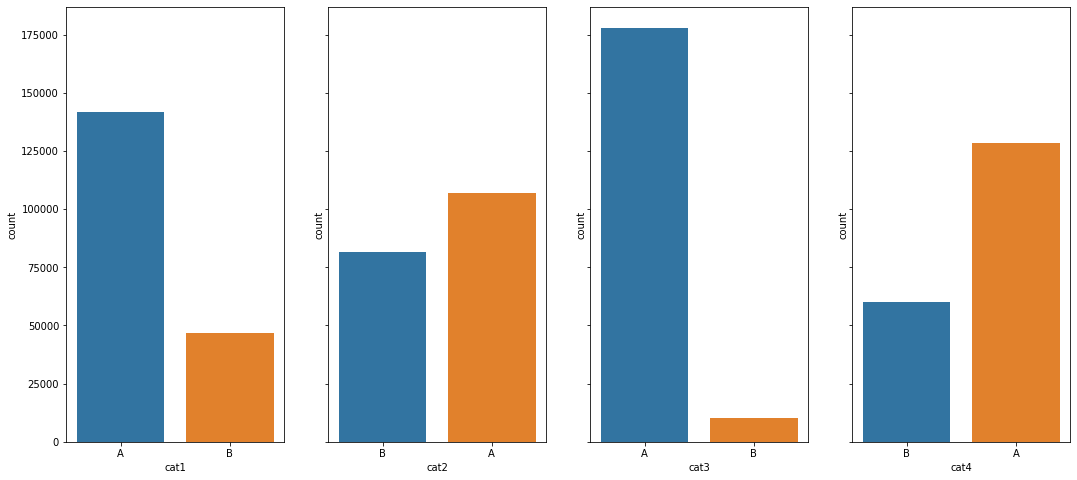

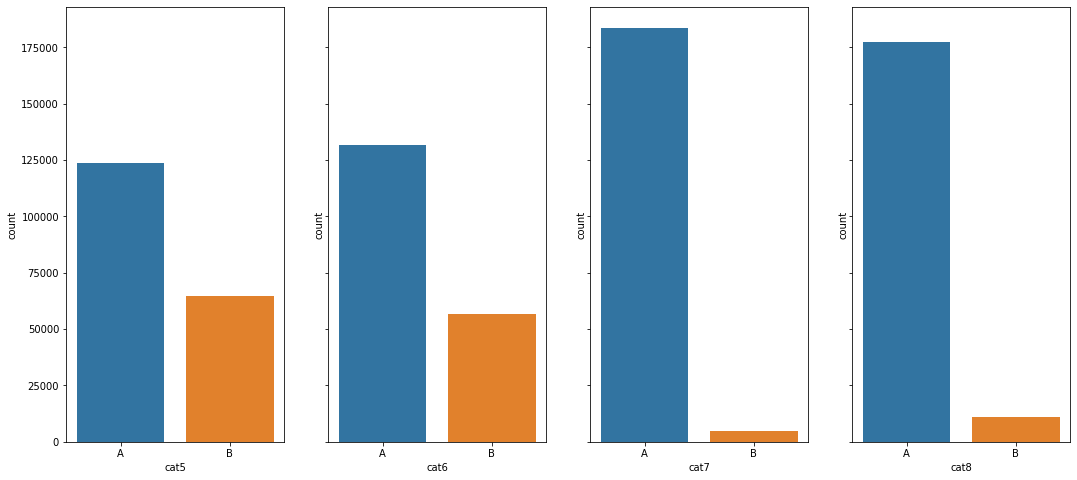

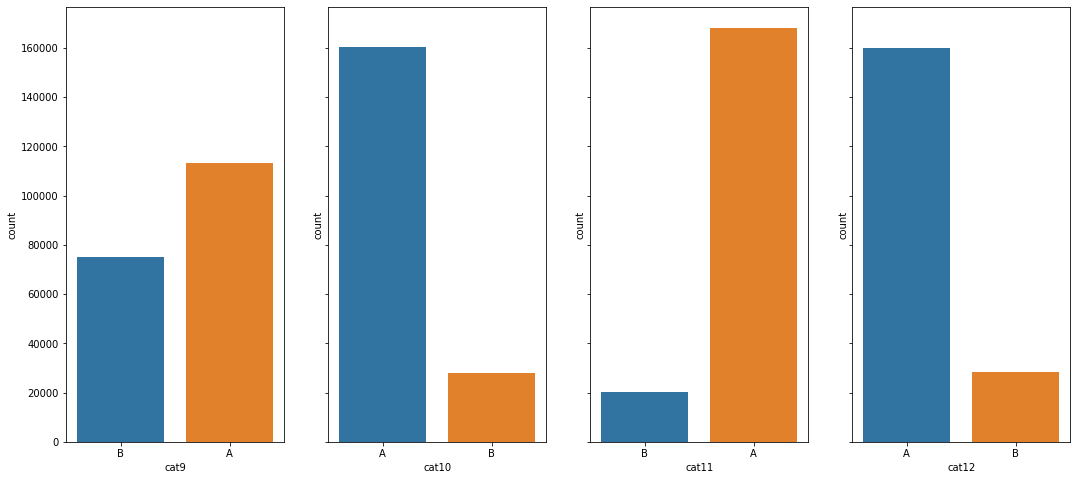

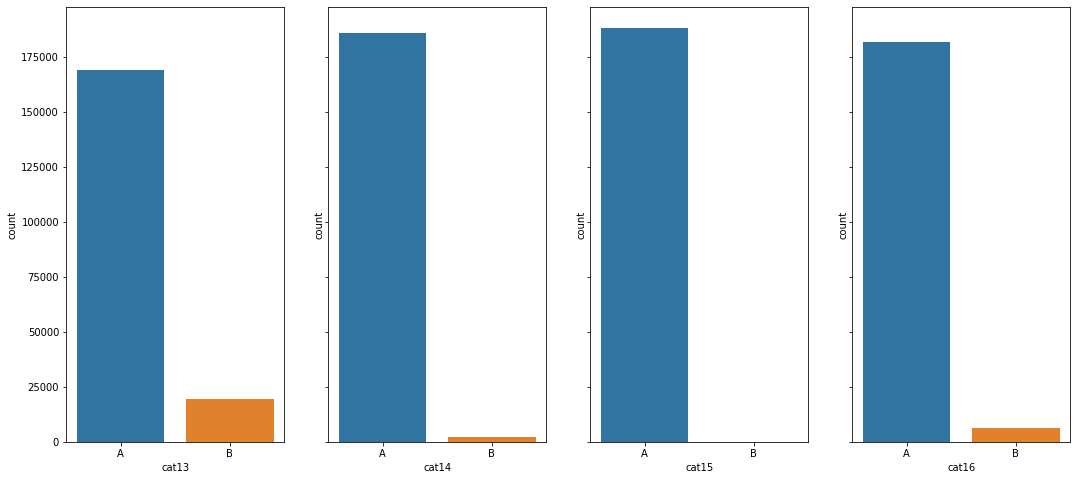

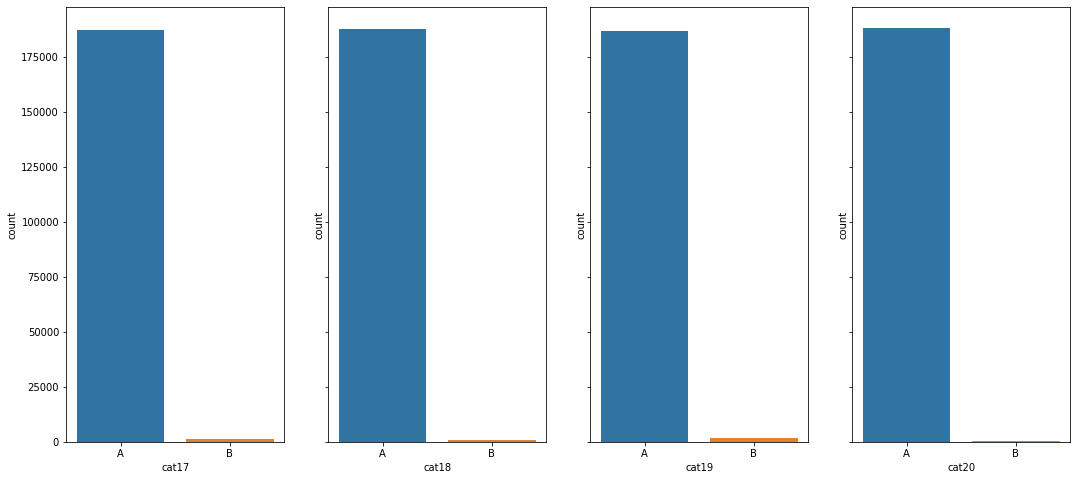

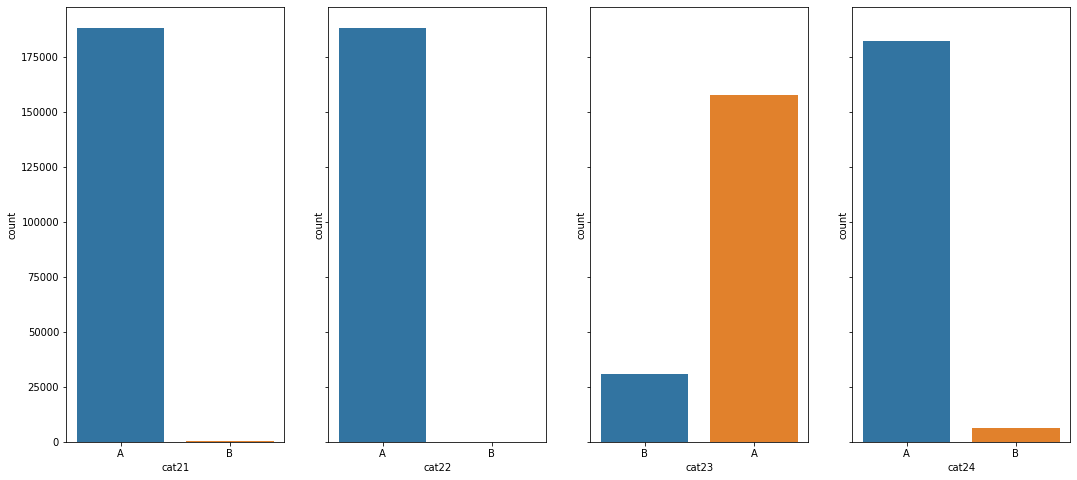

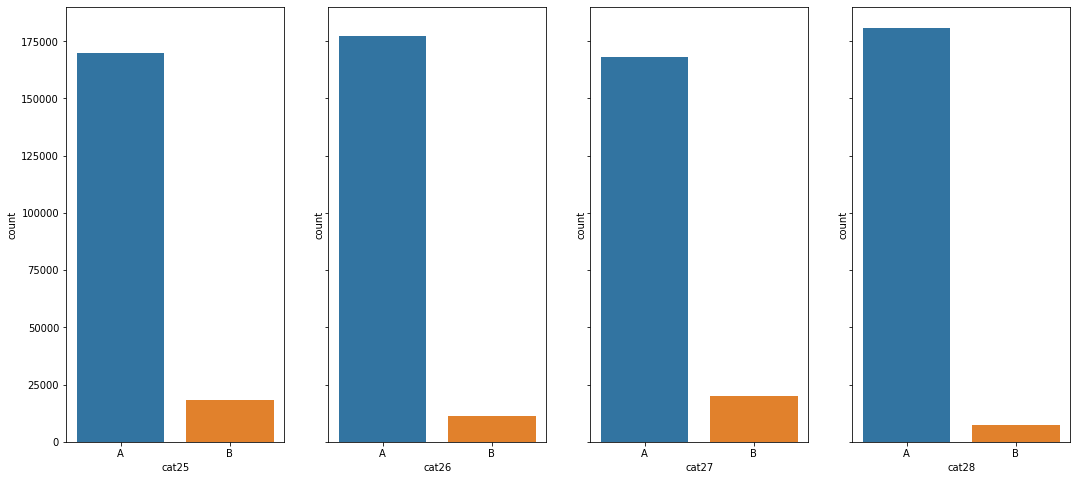

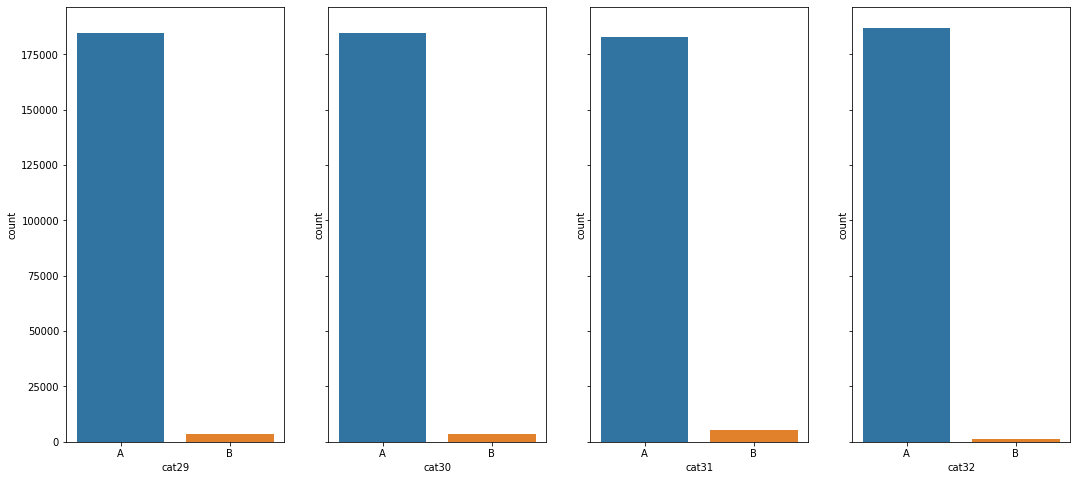

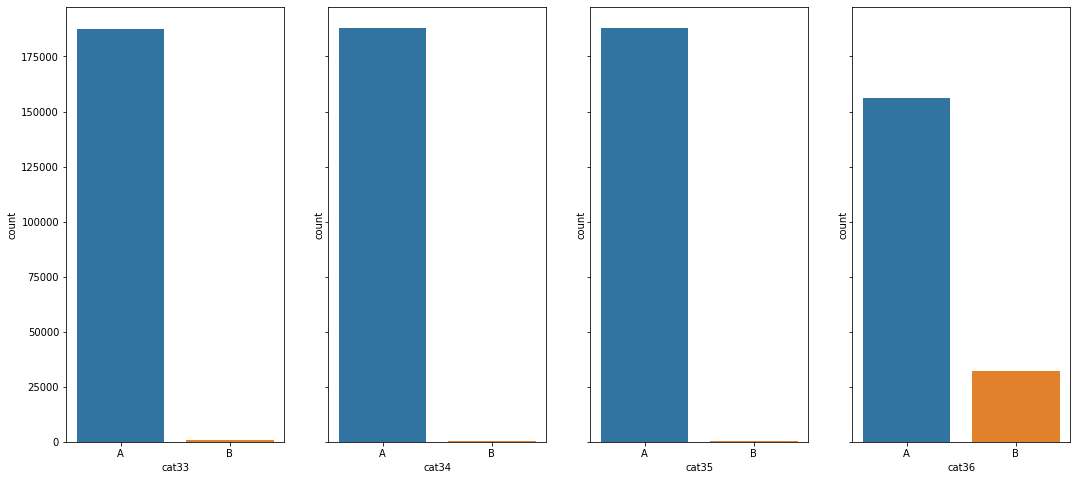

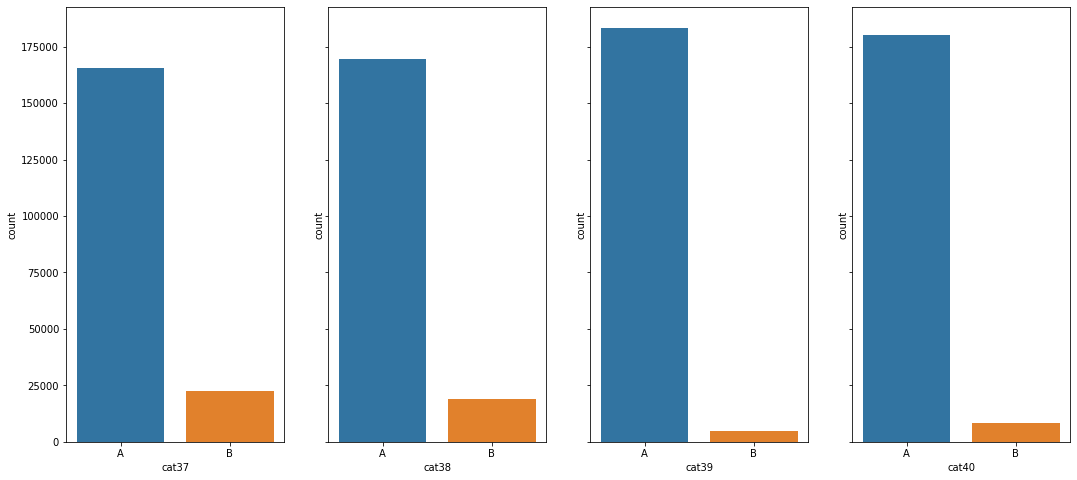

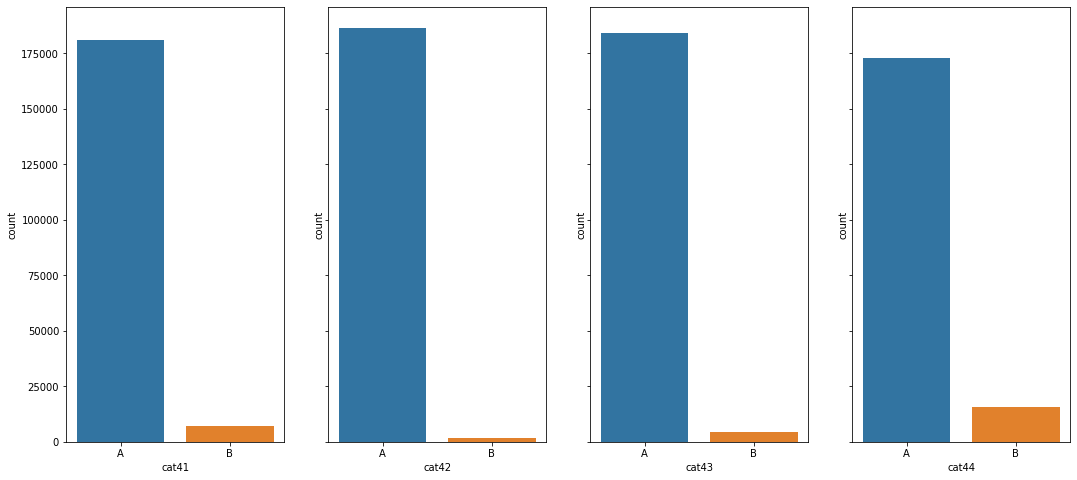

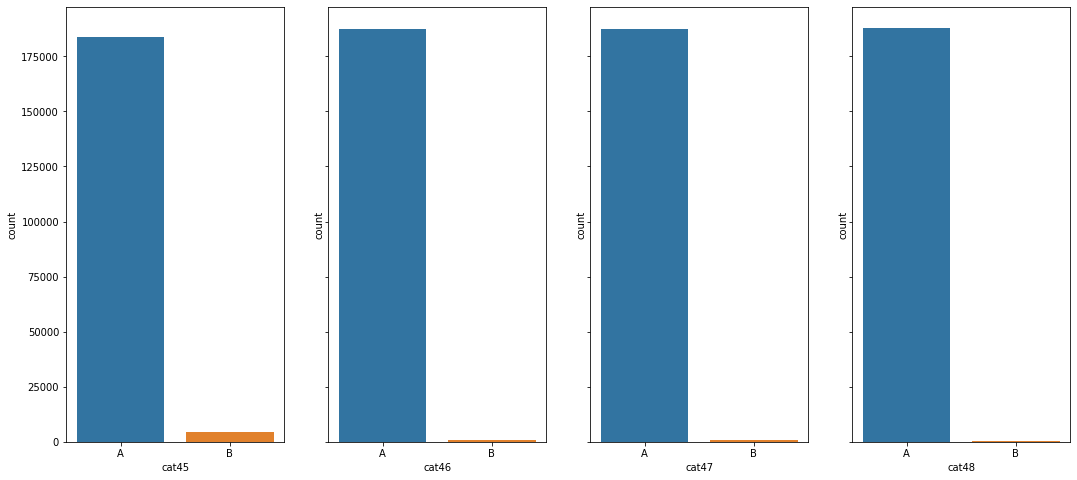

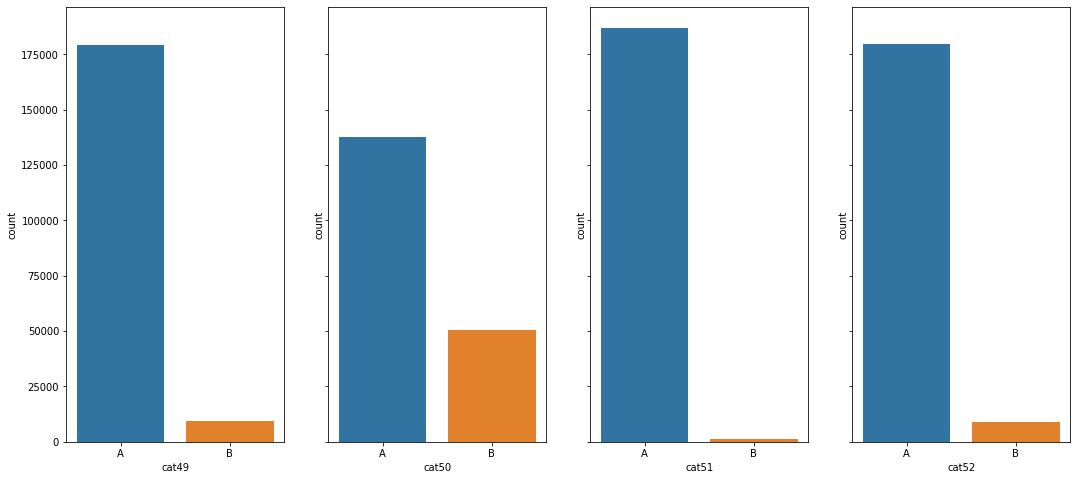

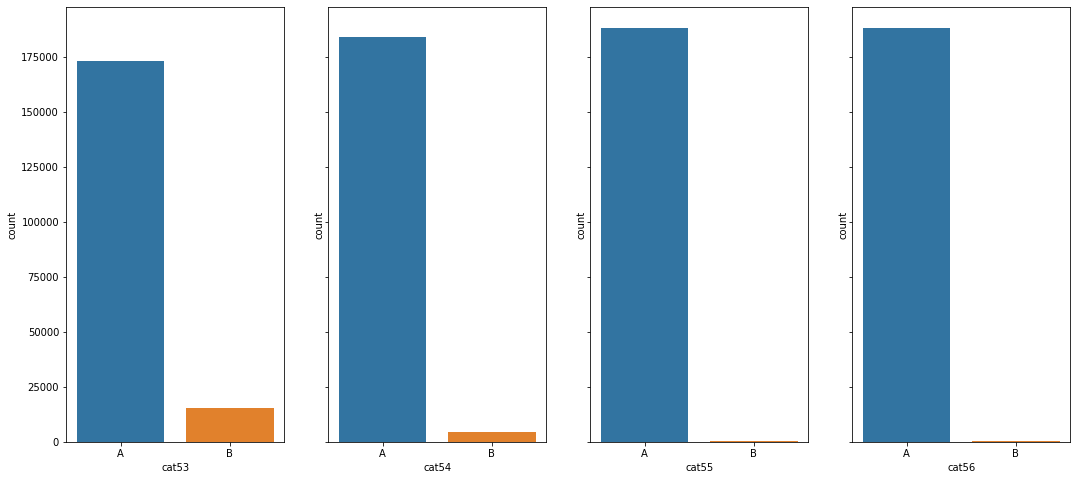

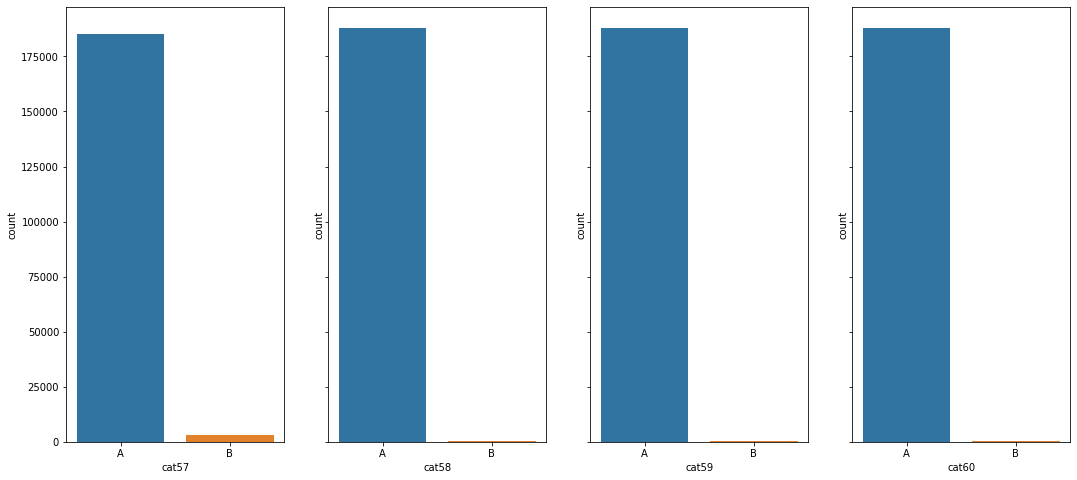

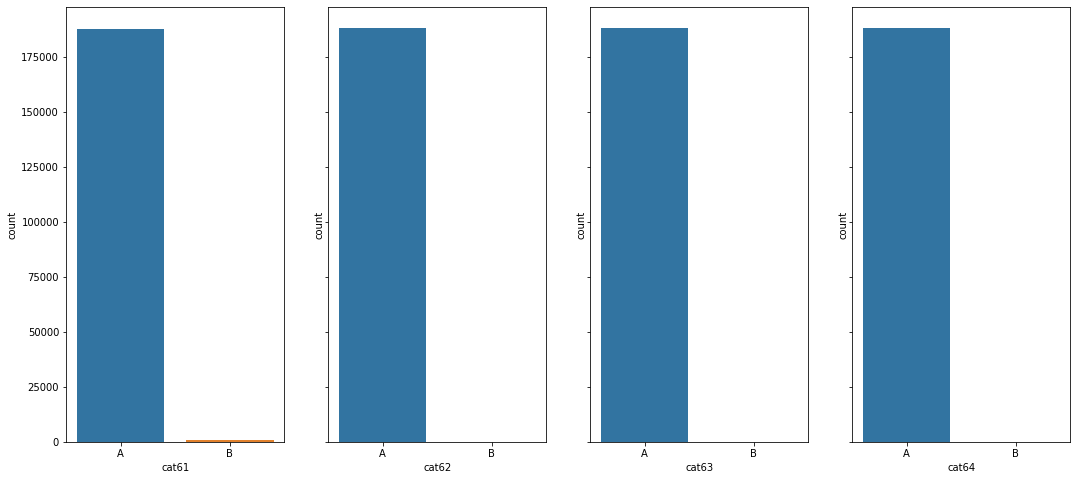

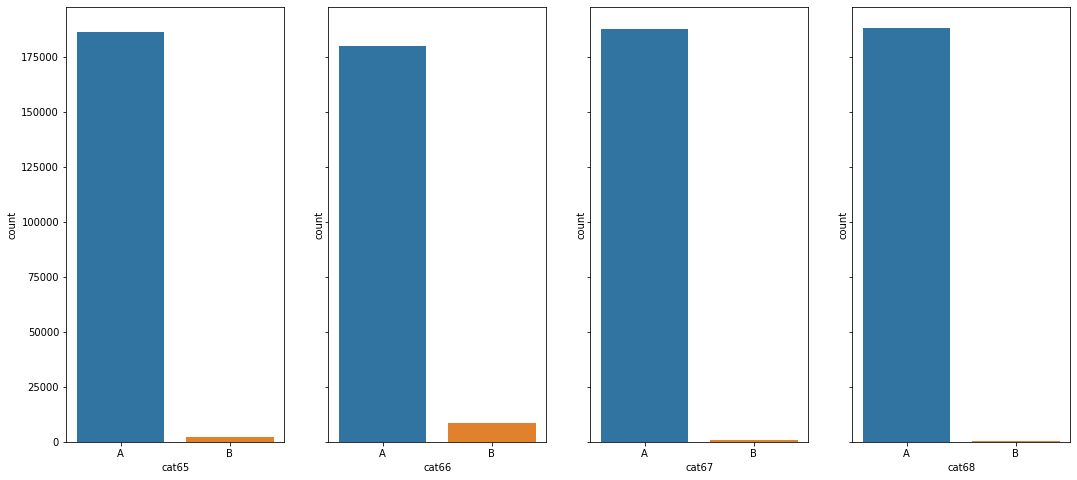

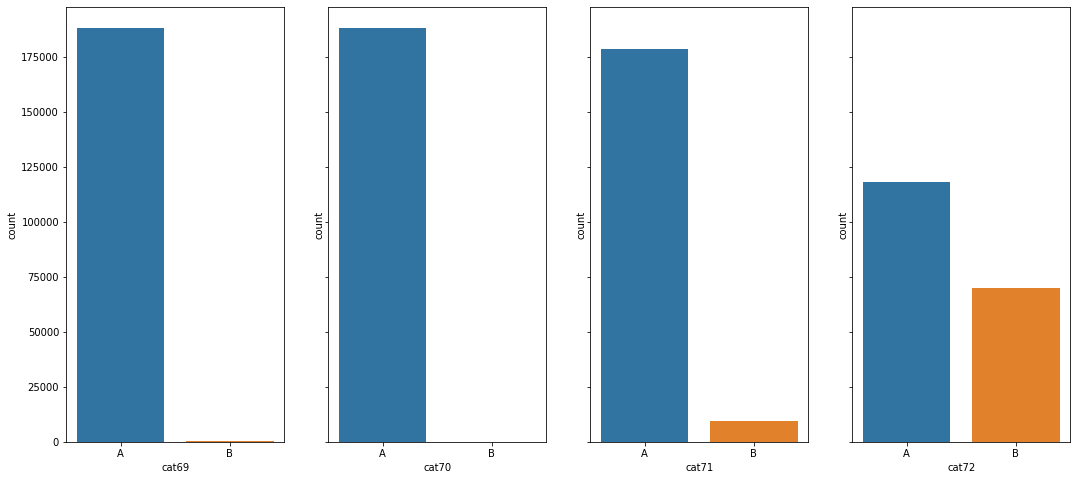

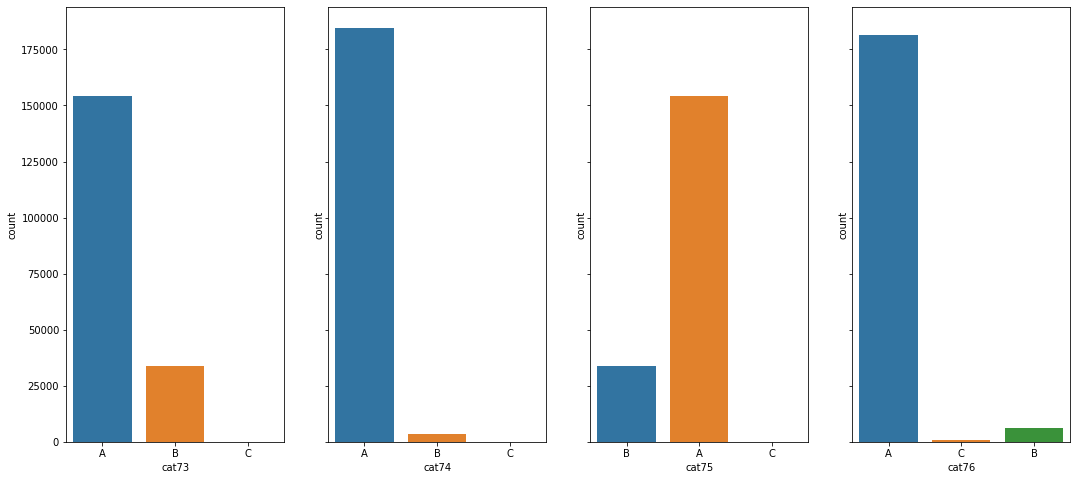

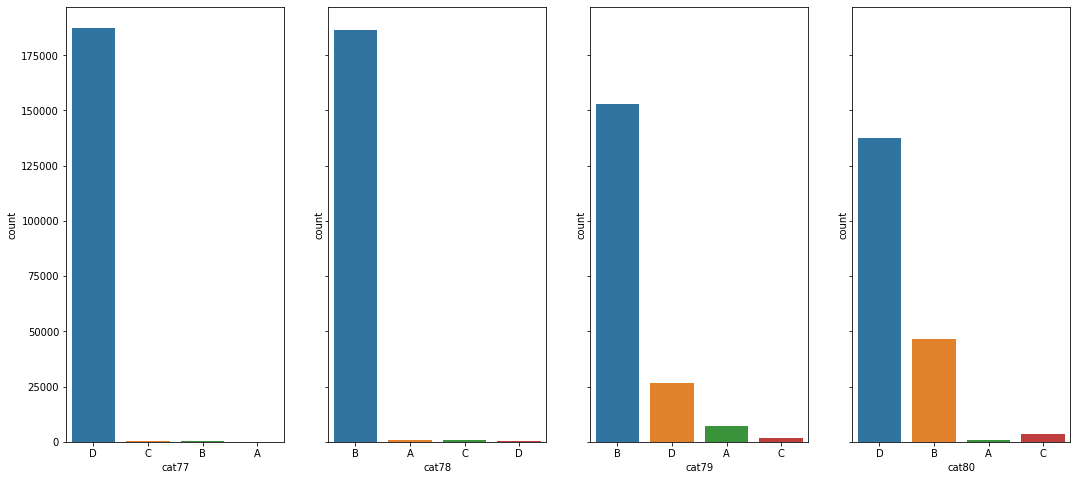

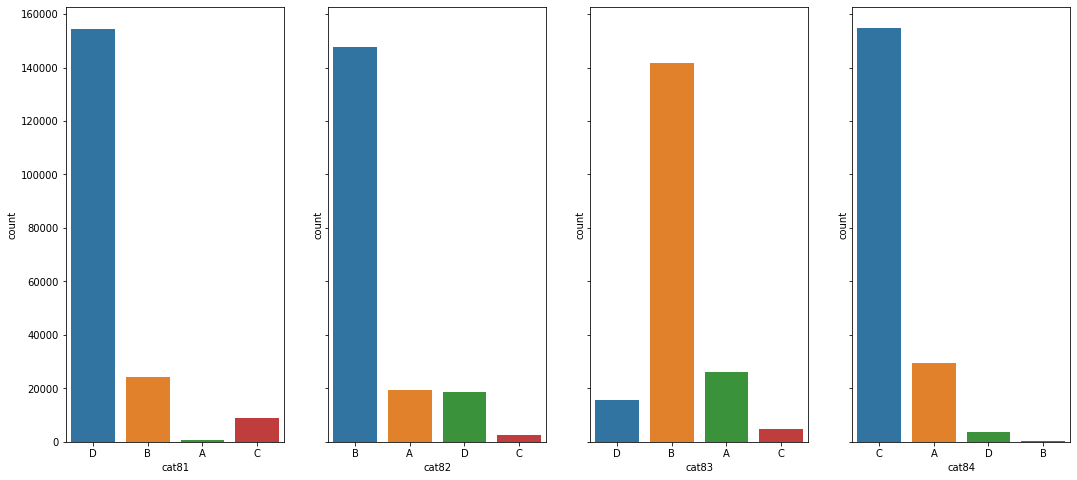

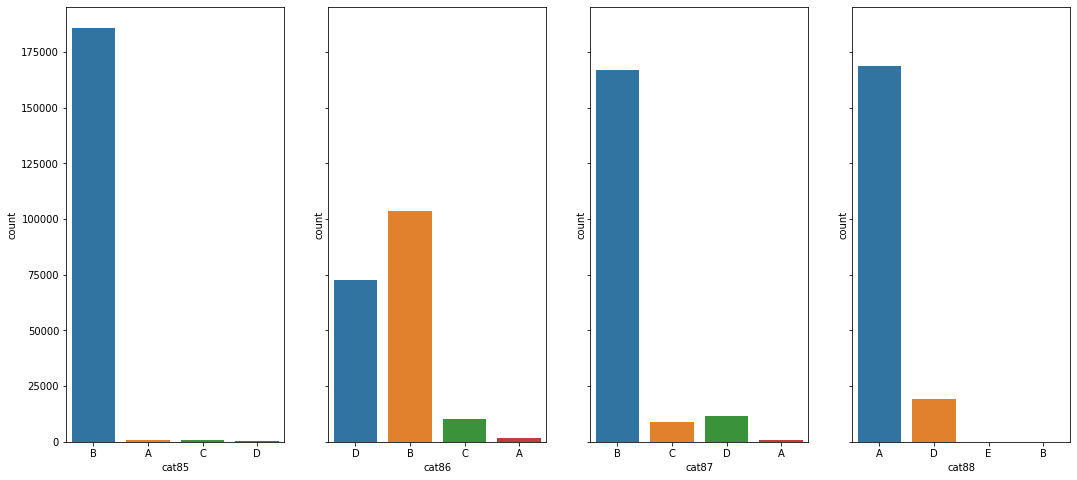

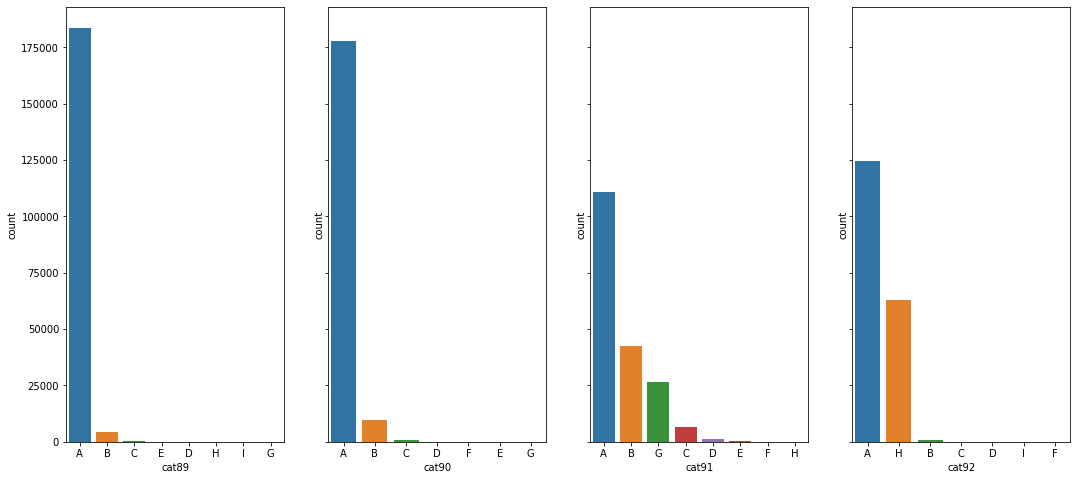

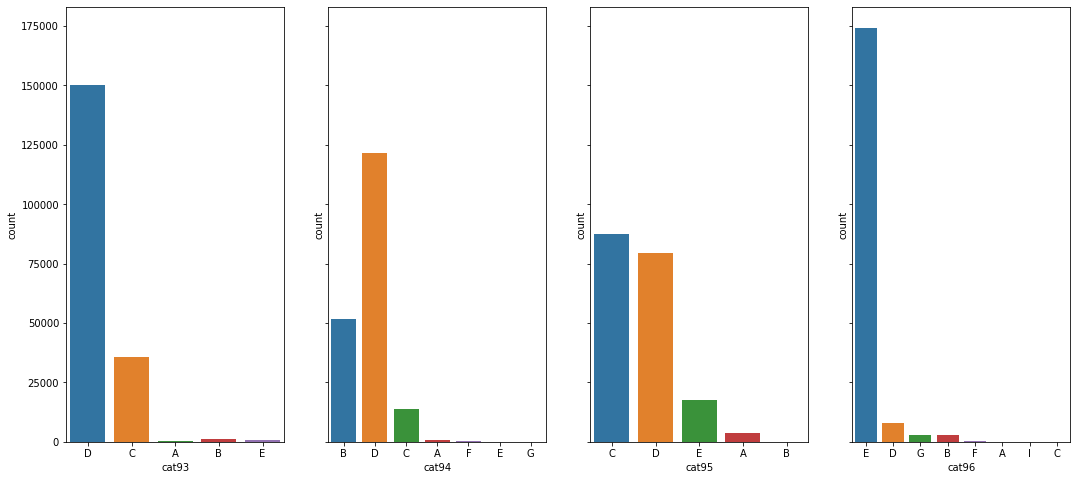

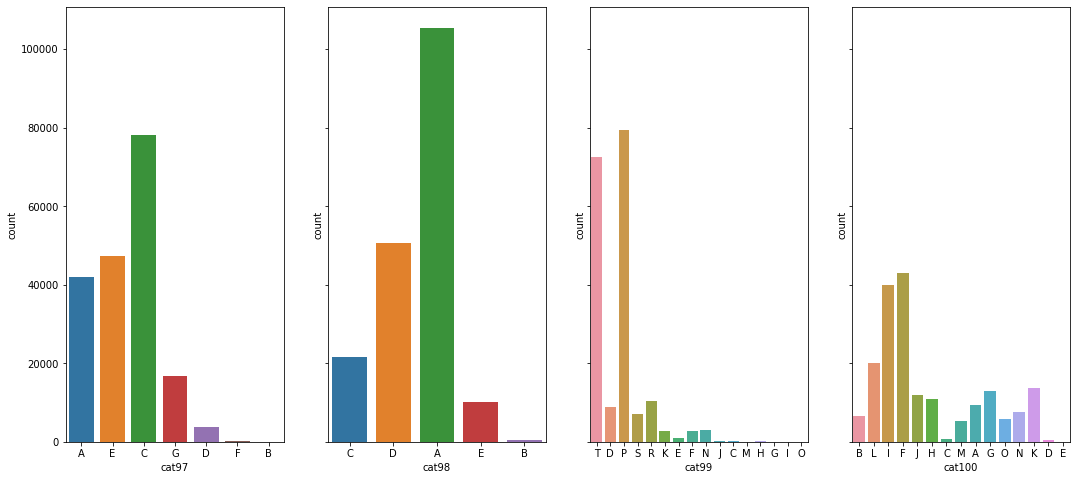

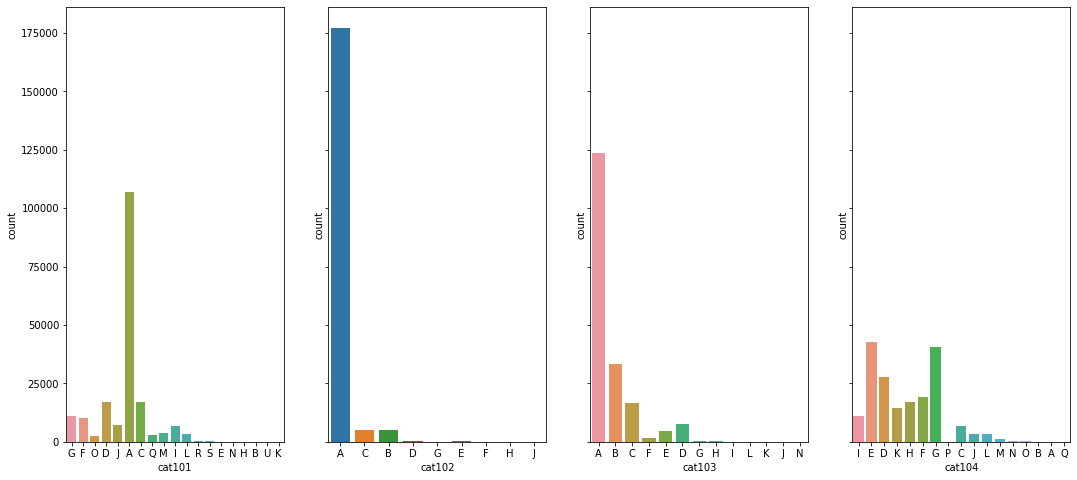

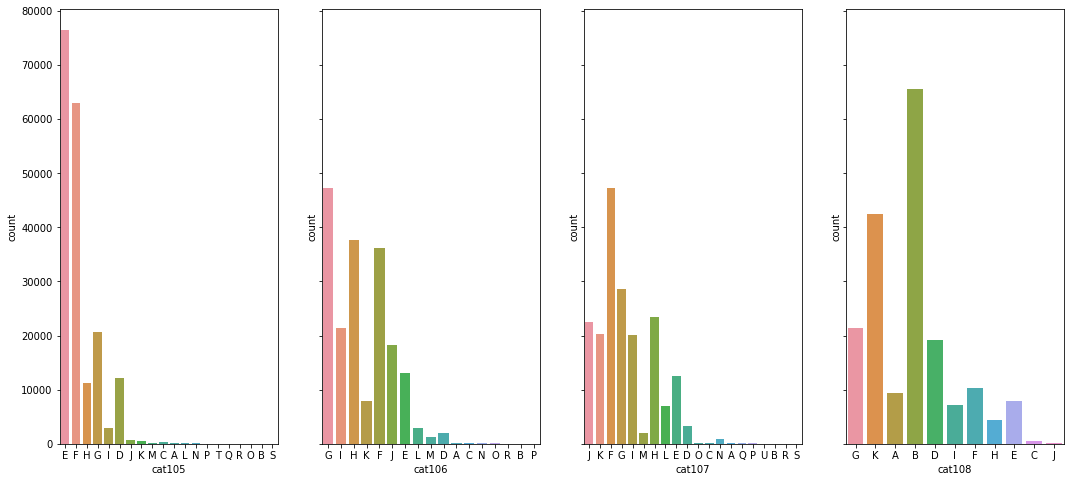

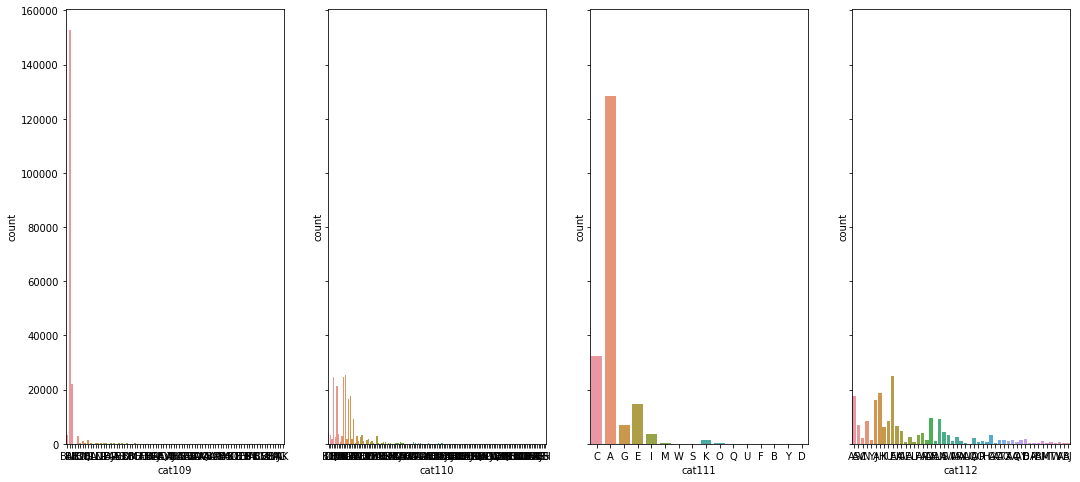

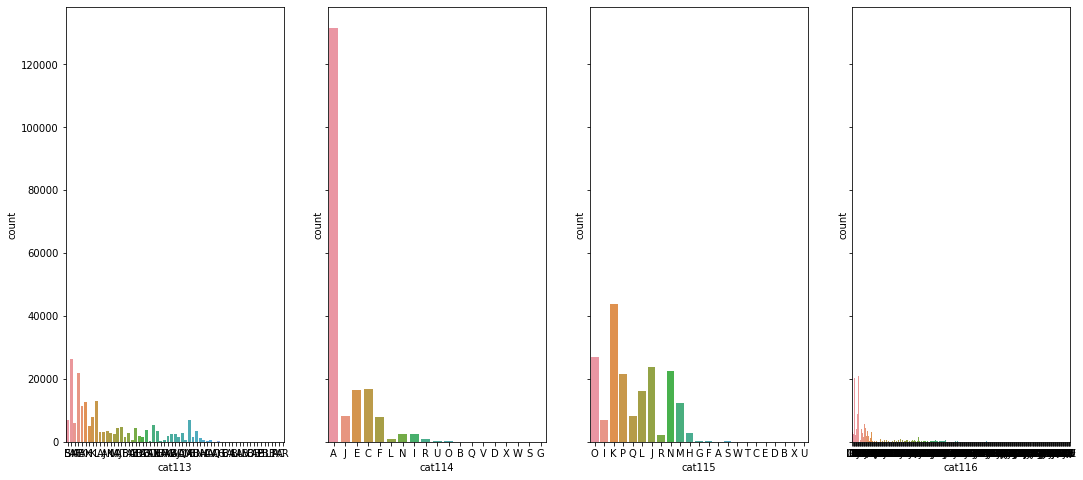

In [14]:
cols = X[cat_columns].columns

# 29x4 형태로 시각화

n_cols = 4
n_rows = 29
for i in range(n_rows):
    fg,ax = plt.subplots(nrows=1,ncols=n_cols,sharey=True,figsize=(18, 8))
    for j in range(n_cols):
        sns.countplot(x=cols[i*n_cols+j], data=train, ax=ax[j])

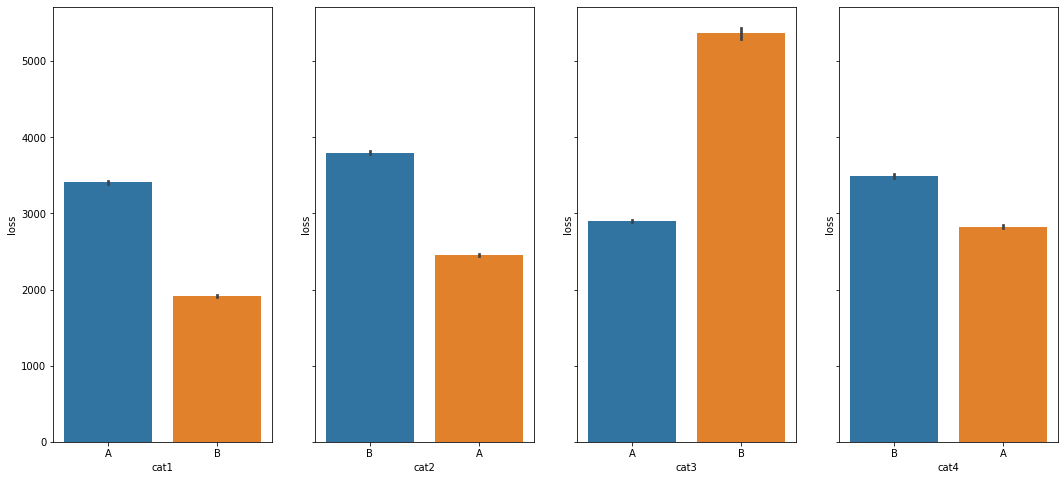

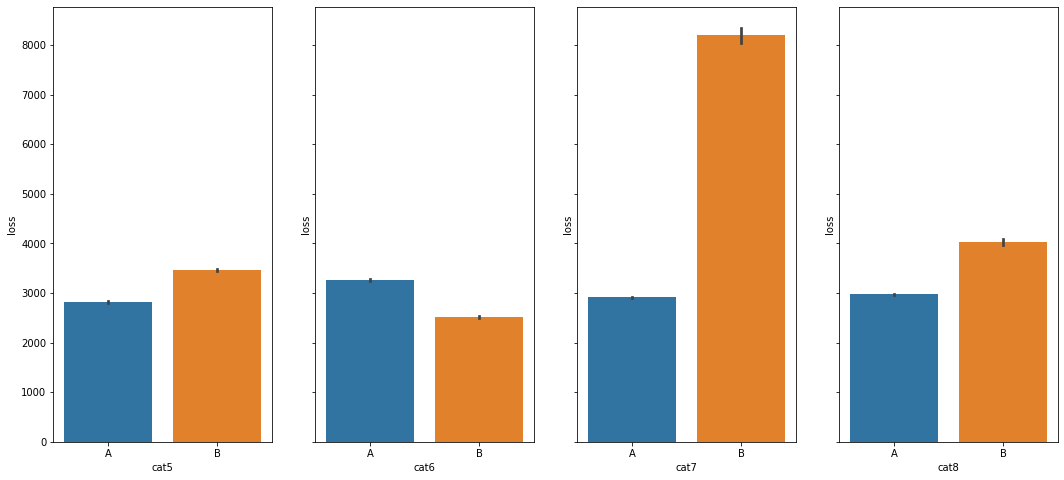

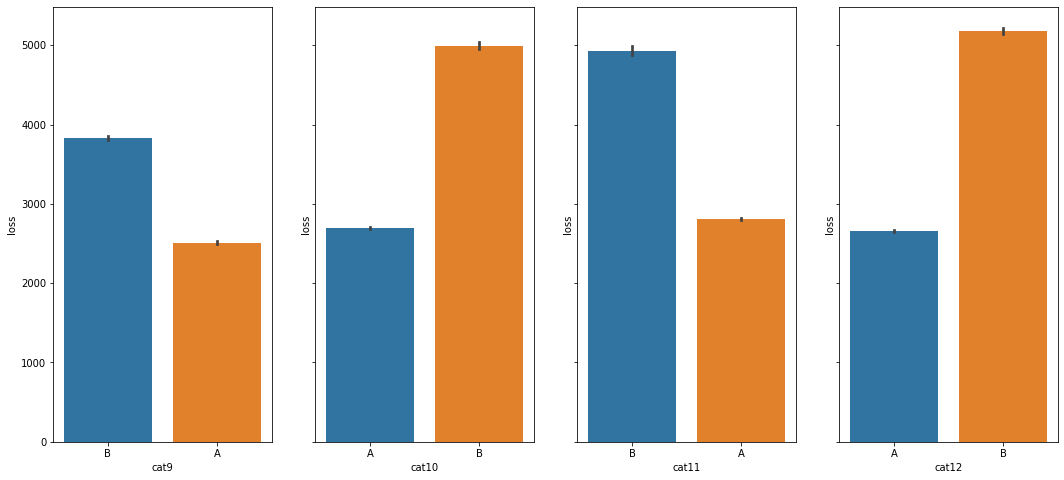

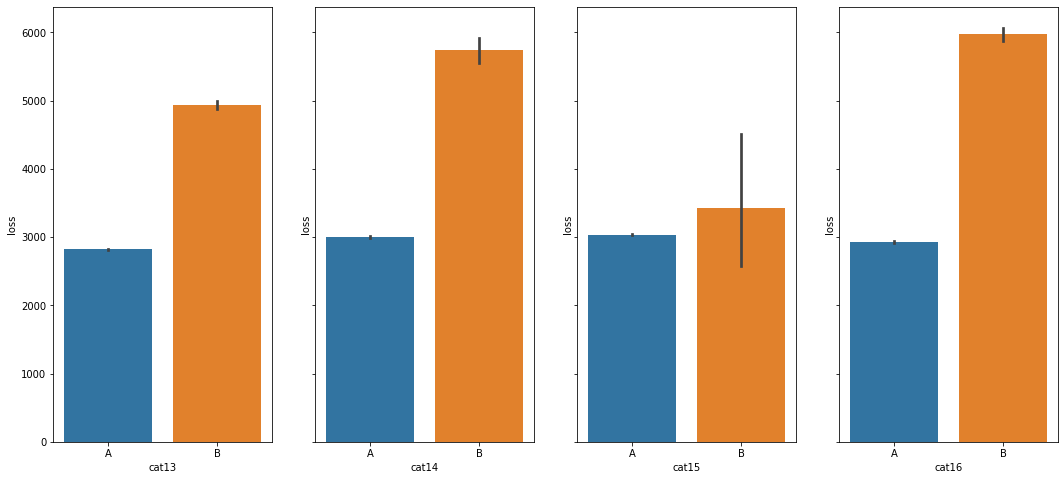

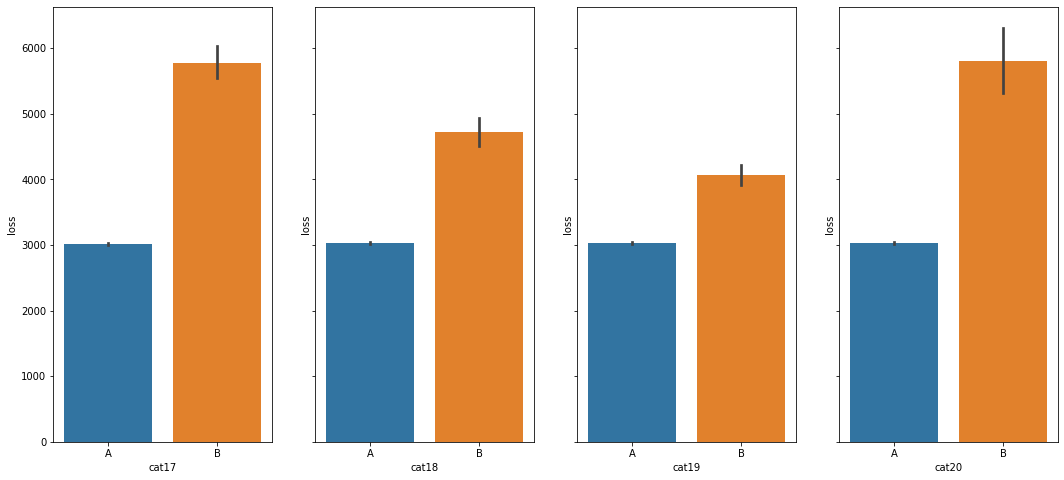

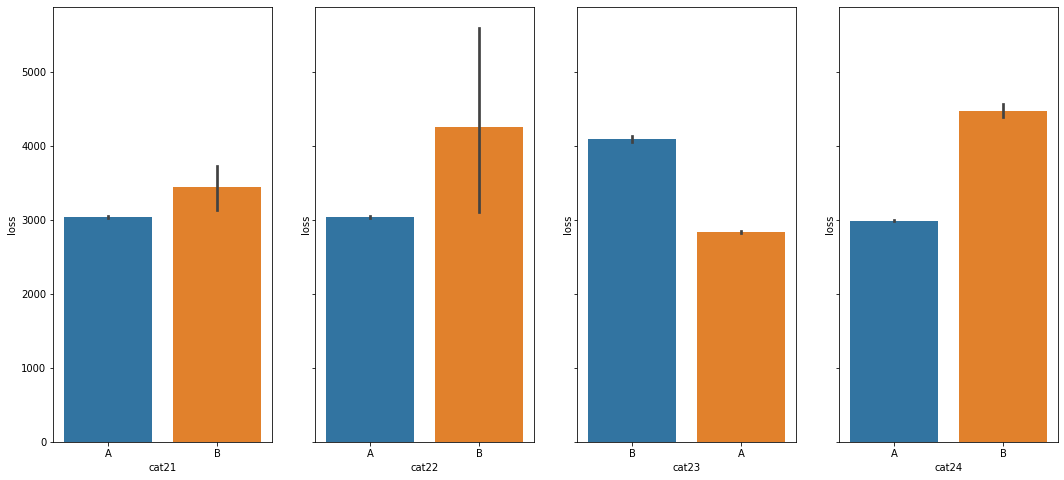

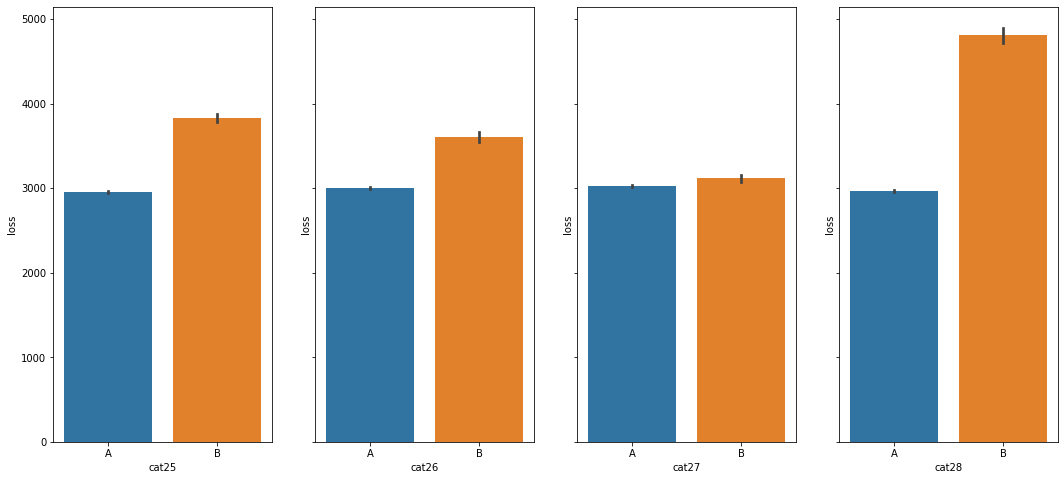

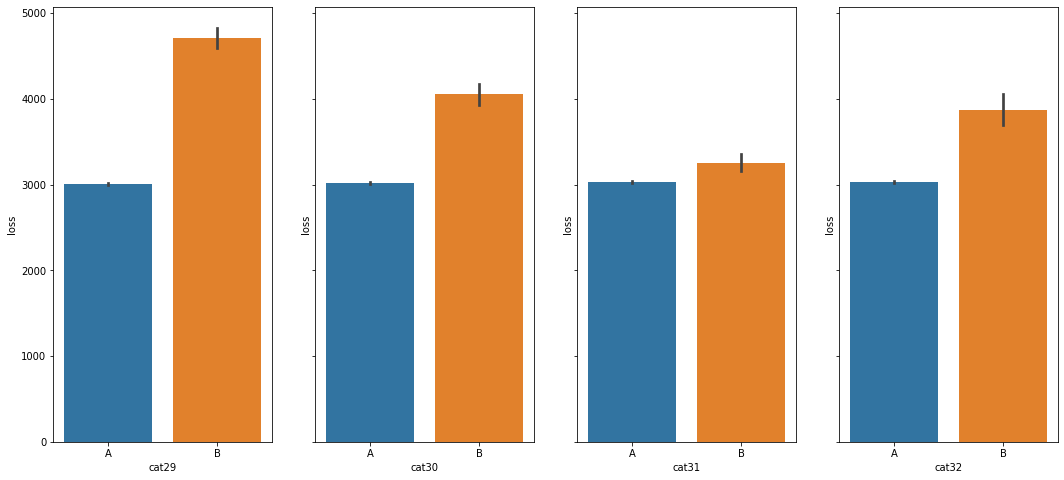

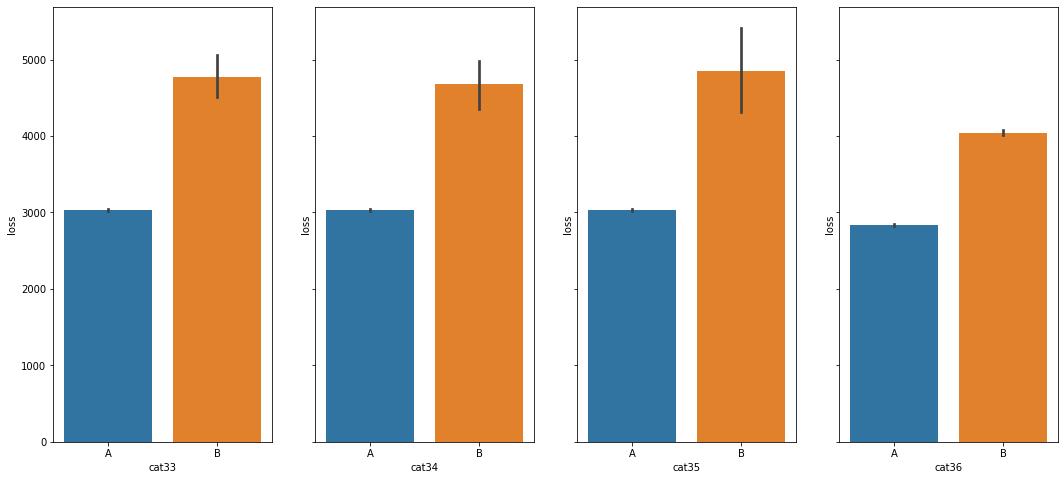

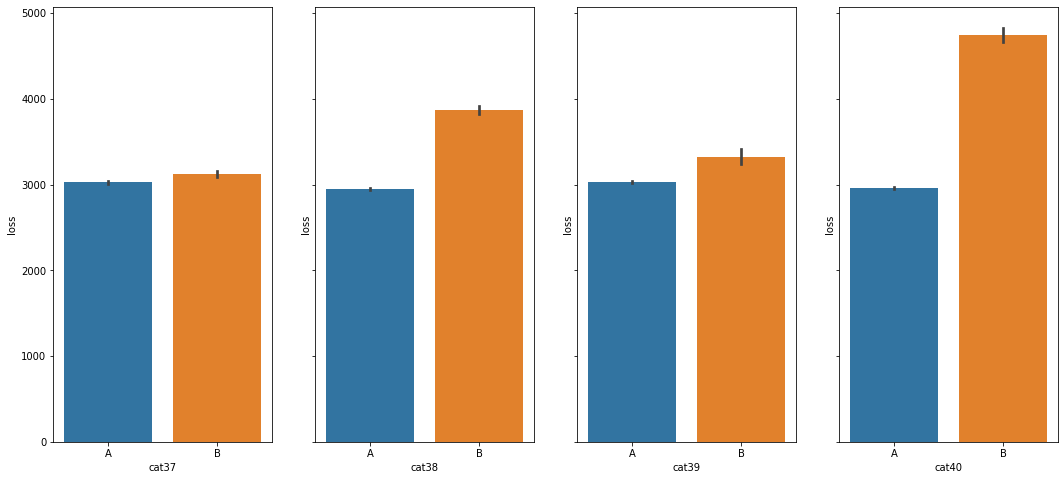

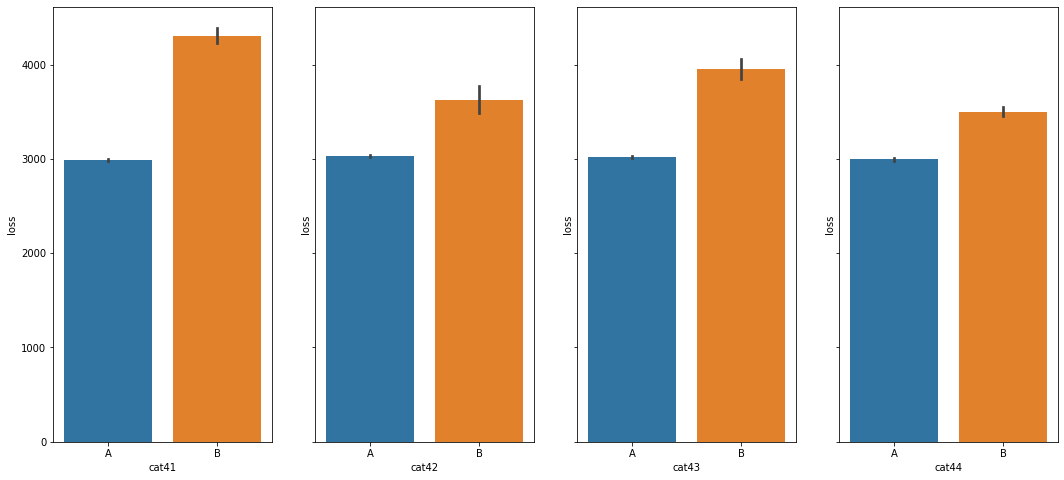

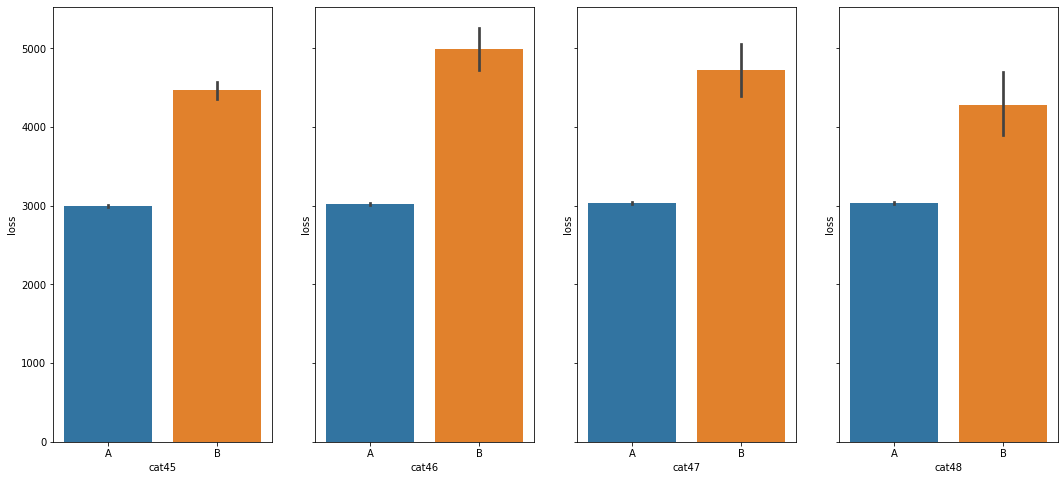

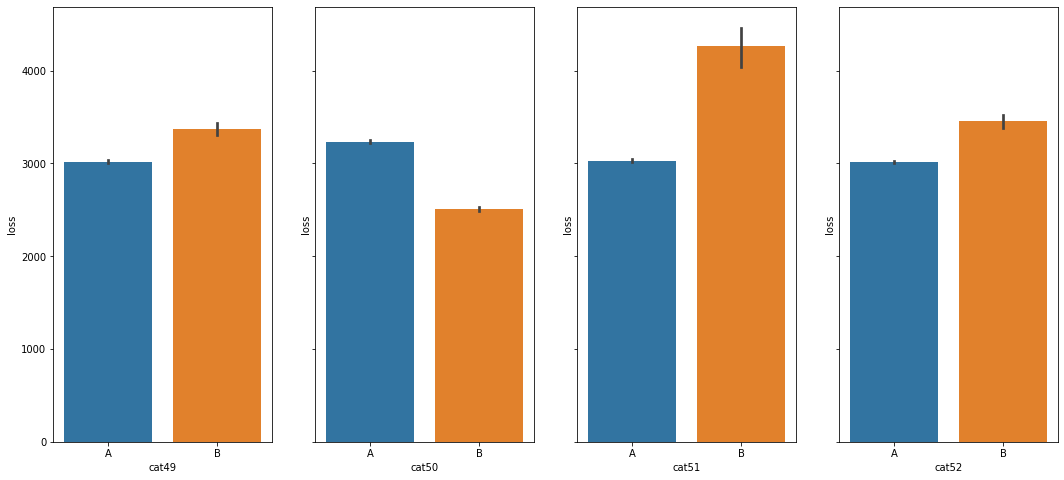

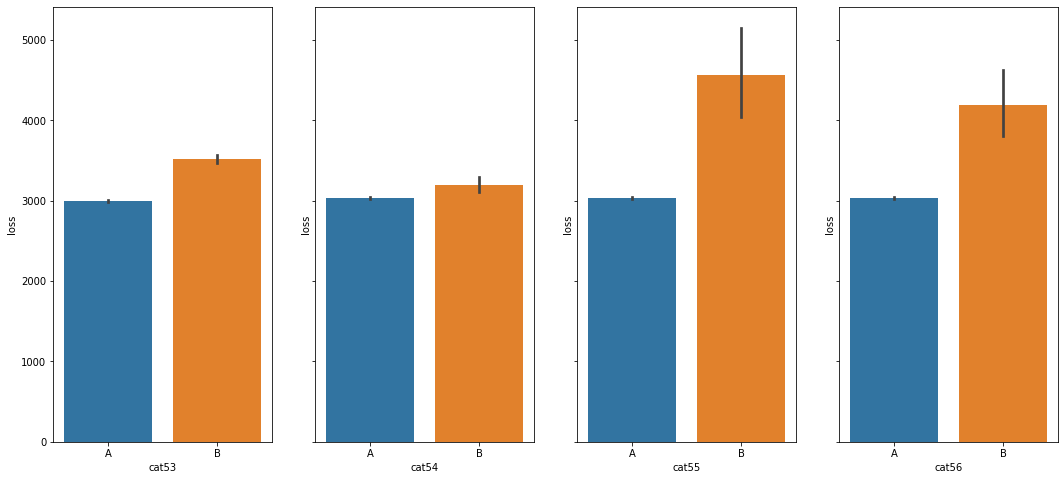

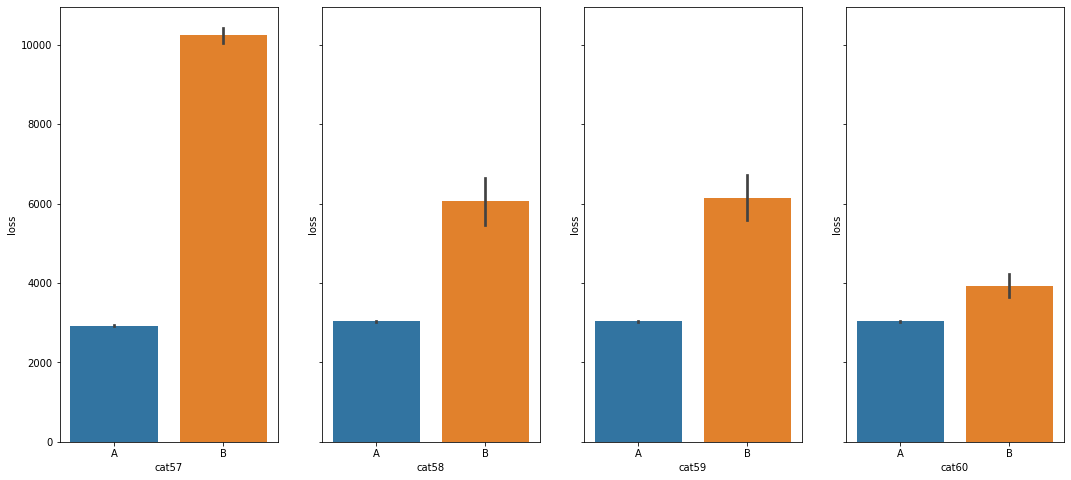

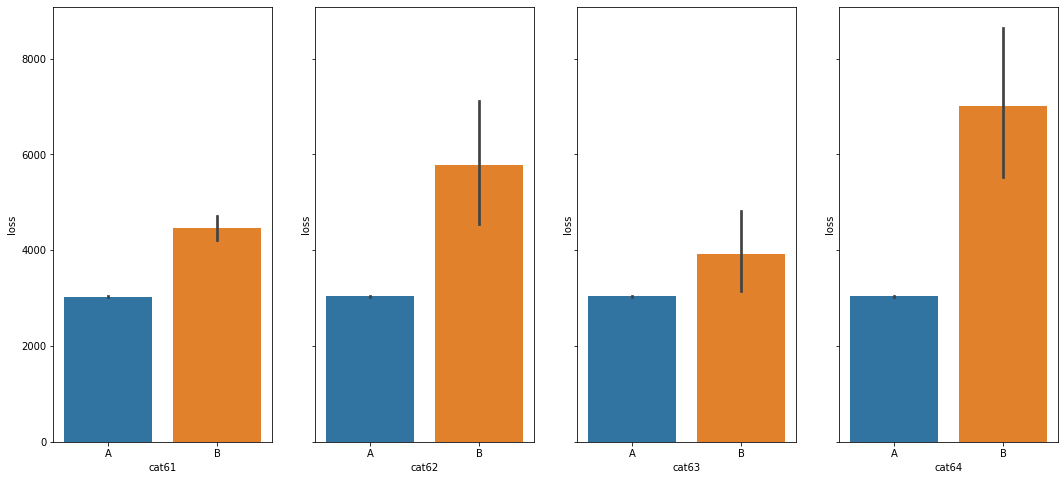

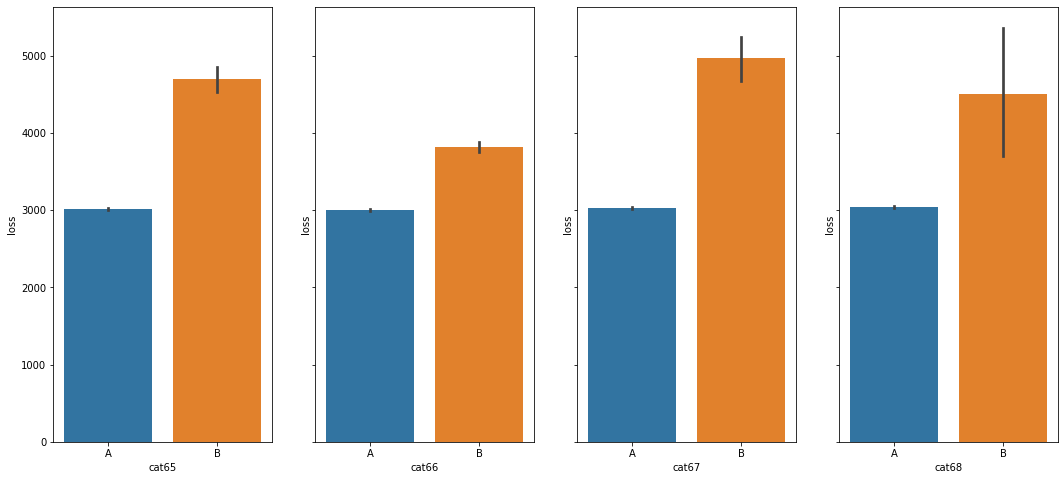

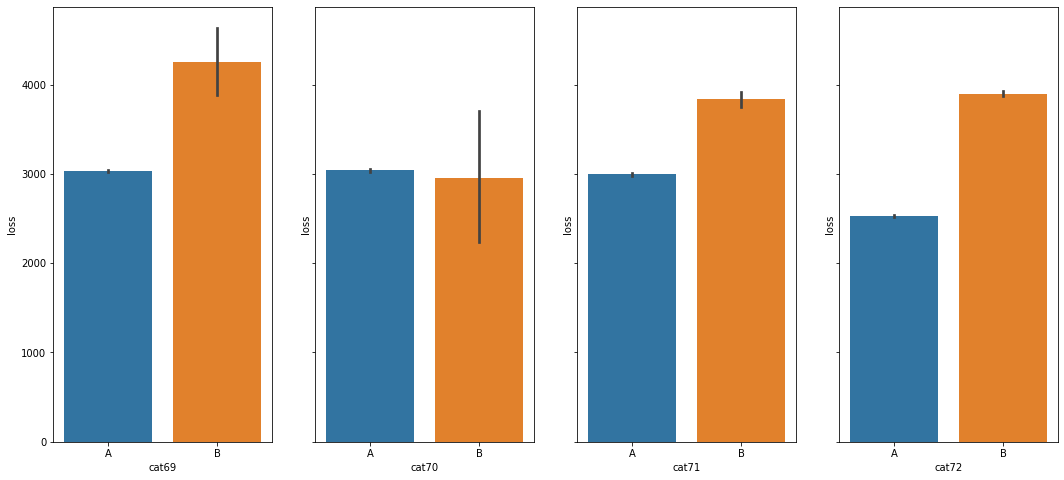

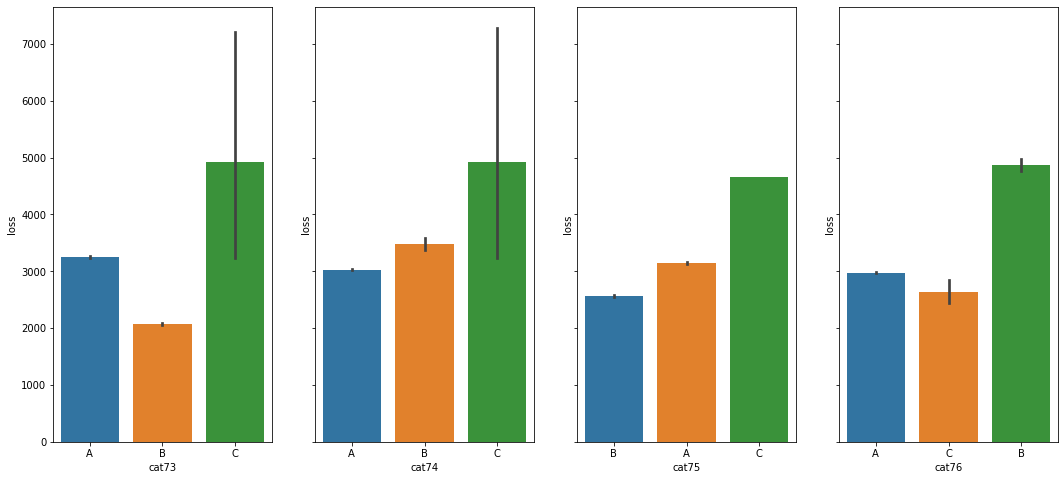

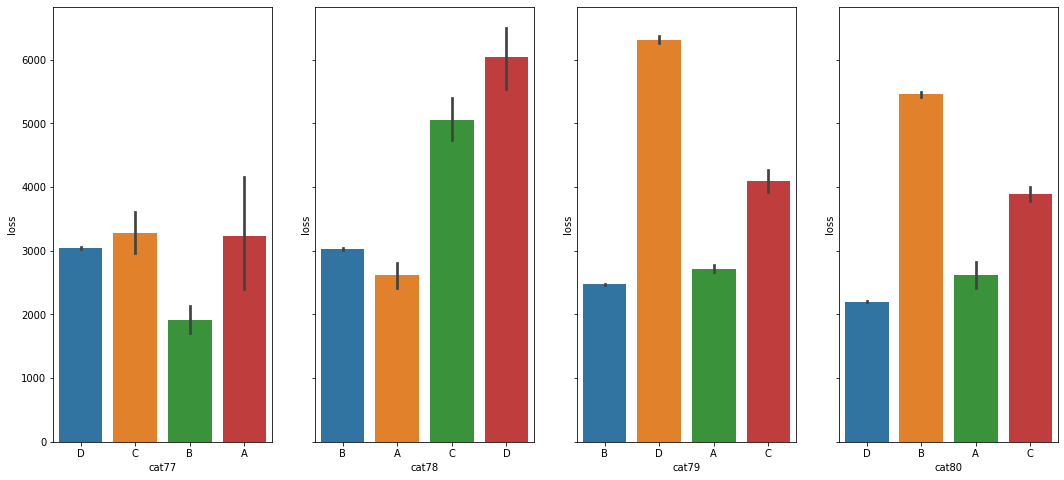

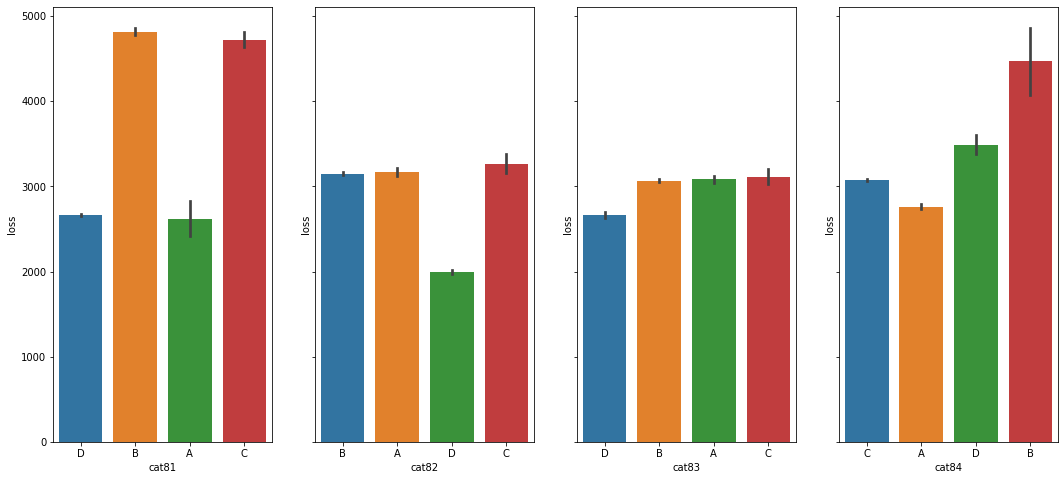

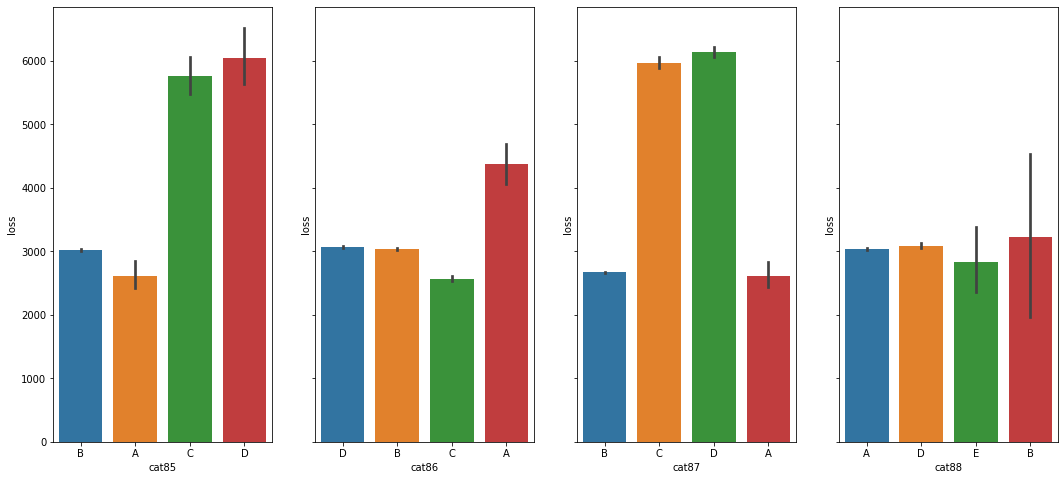

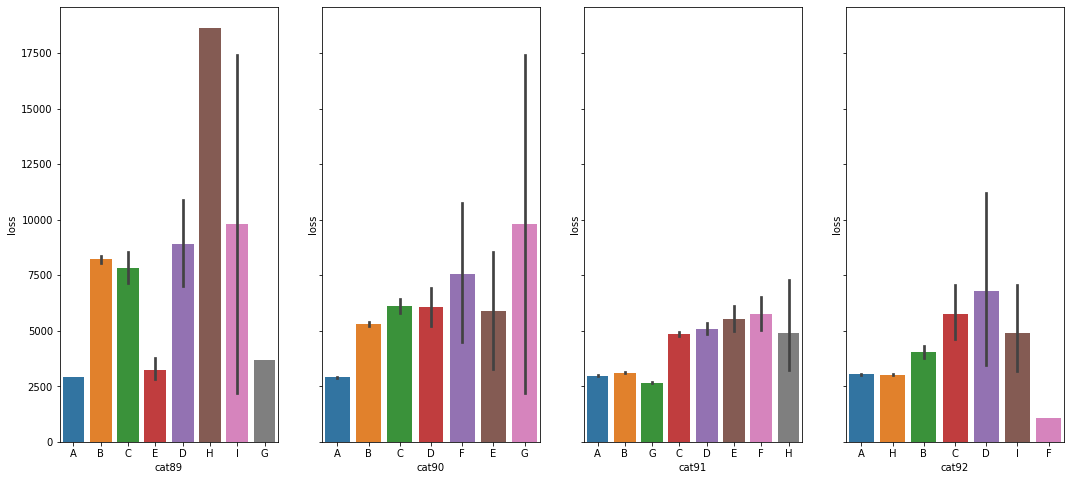

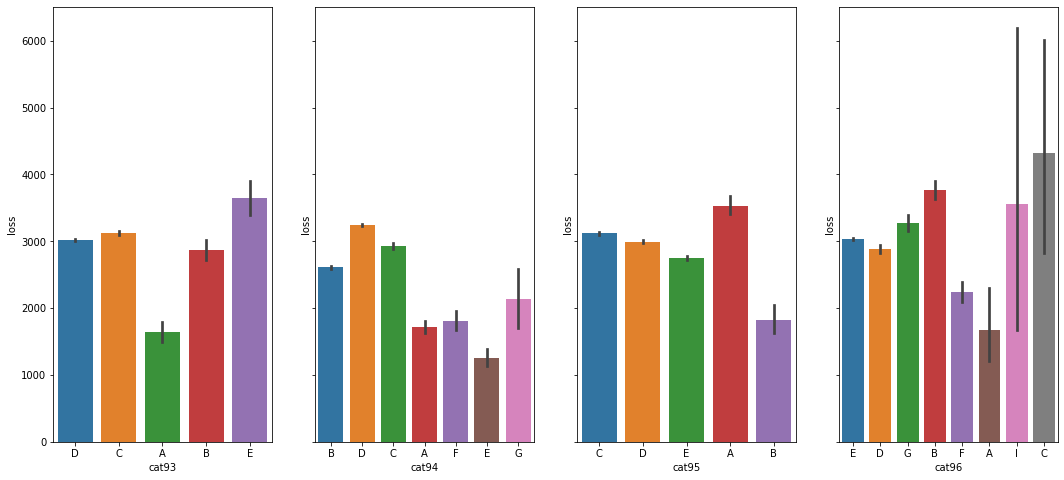

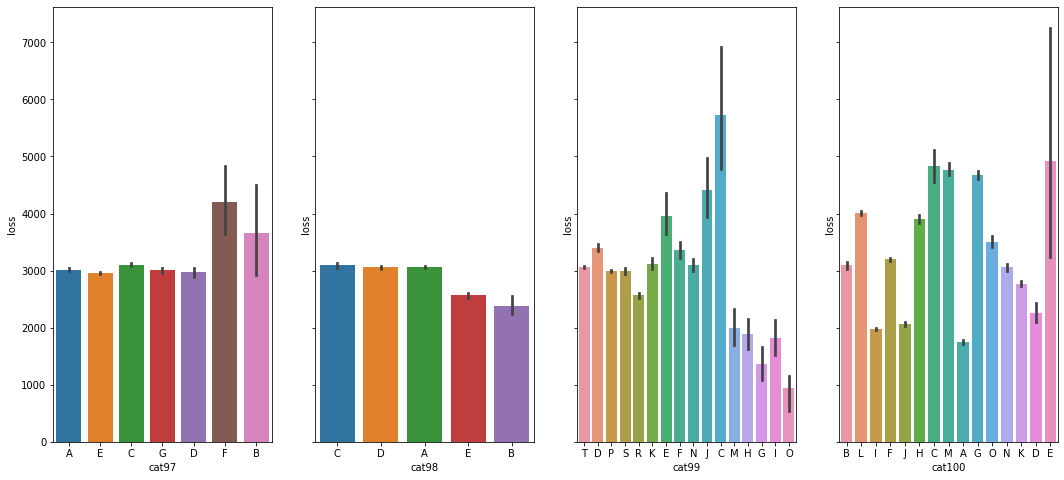

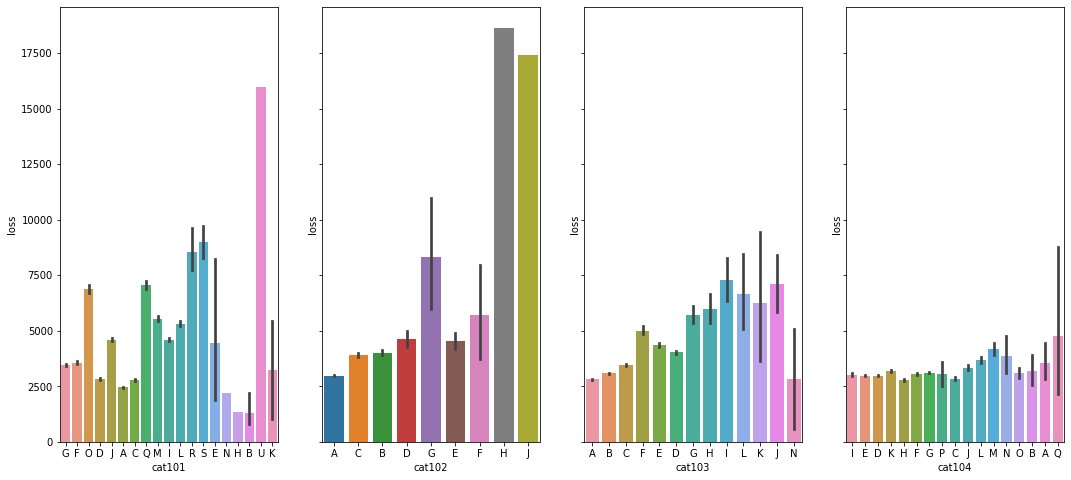

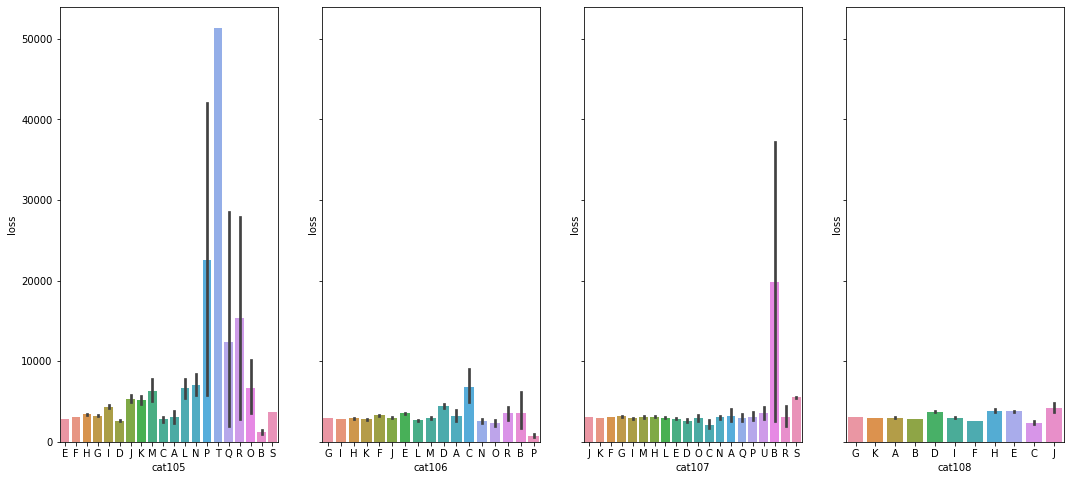

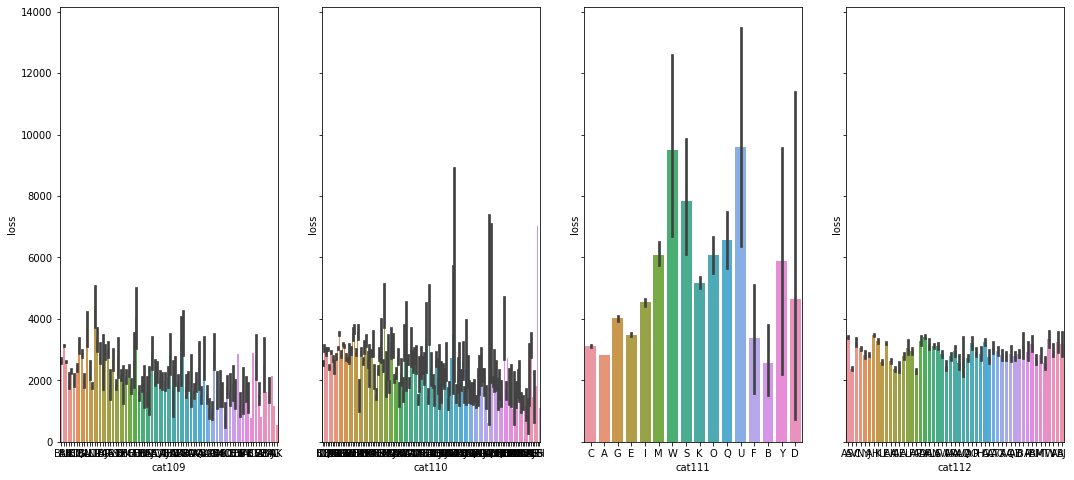

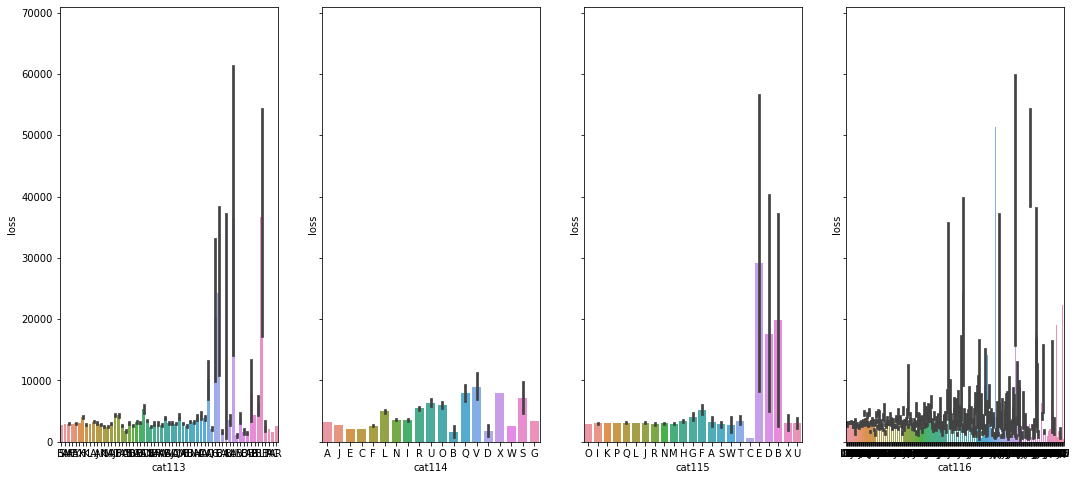

In [12]:
# 범주간 평균 loss값 시각화
cols = X[cat_columns].columns
n_cols = 4
n_rows = 29
for i in range(n_rows):
    fg,ax = plt.subplots(nrows=1,ncols=n_cols,sharey=True,figsize=(18, 8))
    for j in range(n_cols):
        sns.barplot(x=cols[i*n_cols+j], y="loss", data=train, ax=ax[j])
        #sns.countplot(x=cols[i*n_cols+j], data=train, ax=ax[j])

### cat변수와 loss의 유의성(평균 차이) 검정
- 범주가 2개인 변수 -> t-test
- 범주가 3개인 변수 -> anova 검정

t-test, anova검정에서 유의확률 0.05이상인 변수는 제외
각 변수의 범주간 평균차가 2000이하 변수는 제외(변수 축소 및 loss와의 차이가 분명한 변수만 활용)

In [26]:
# cat 변수와 loss값에 유의미한 차이(평균의 차이)가 있는 변수만 설정
X_cat = pd.concat([X_cat, y], axis=1)

# 범주가 2개인 변수는 t-test, 3개 이상인 변수는 anova검정을 통해 유의미한 변수만 추출
mean_significant = []
for cat in X_cat.drop(columns=['loss']).columns :
    # 각 컬럼별 unique 갯수가 2면 t-test, 3이상이면 Anova분석으로 진행
    tmp_unique_len = len(X_cat[cat].unique())
    
    # t- test
    if tmp_unique_len == 2 :
        ttest_val = []
        
        for u_len in range(0,tmp_unique_len) :
            ttest_val.append(X_cat[cat].unique()[u_len])
            
        tmp_a = X_cat['loss'][X_cat[cat] == ttest_val[0]]
        tmp_b = X_cat['loss'][X_cat[cat] == ttest_val[1]]
        tmp_ttest_pValue = st.ttest_ind(tmp_a, tmp_b, equal_var=False)[1]
        if  tmp_ttest_pValue < 0.05 :
            mean_significant.append(cat)
            print(f'''{cat}의 p-value : {st.ttest_ind(tmp_a, tmp_b, equal_var=False)[1]}''')
        else :
            print(f'''{cat}의 p-value : {st.ttest_ind(tmp_a, tmp_b, equal_var=False)[1]} <- 변수 삭제''')
            
    
    # anova 검정
    else:
        anova_val = []
        
        for u_len in range(0,tmp_unique_len) :
            anova_val.append(X_cat[cat].unique()[u_len])
        
        tmp_anova_pValue = st.f_oneway(*(X_cat['loss'][X_cat[cat] == val] for val in anova_val))[1]
        if tmp_anova_pValue < 0.05 :
            mean_significant.append(cat)
            print(f'''{cat}의 p-value : {st.f_oneway(*(X_cat['loss'][X_cat[cat] == val] for val in anova_val))[1]}''')
        else :
            print(f'''{cat}의 p-value : {st.f_oneway(*(X_cat['loss'][X_cat[cat] == val] for val in anova_val))[1]}''')
            

X_cat = X_cat[mean_significant]
X_cat = pd.concat([X_cat, y], axis=1)

cat1의 p-value : 0.0
cat2의 p-value : 0.0
cat3의 p-value : 0.0
cat4의 p-value : 0.0
cat5의 p-value : 0.0
cat6의 p-value : 0.0
cat7의 p-value : 0.0
cat8의 p-value : 1.4979766349203168e-204
cat9의 p-value : 0.0
cat10의 p-value : 0.0
cat11의 p-value : 0.0
cat12의 p-value : 0.0
cat13의 p-value : 0.0
cat14의 p-value : 1.2361218061591765e-153
cat15의 p-value : 0.43750662953388264 <- 변수 삭제
cat16의 p-value : 0.0
cat17의 p-value : 3.839976925548235e-88
cat18의 p-value : 1.4648627010130848e-45
cat19의 p-value : 3.0908965237561634e-35
cat20의 p-value : 8.928356951280945e-21
cat21의 p-value : 0.008468701195802819
cat22의 p-value : 0.06836766221060617 <- 변수 삭제
cat23의 p-value : 0.0
cat24의 p-value : 9.80417356606437e-200
cat25의 p-value : 1.3106481073902833e-243
cat26의 p-value : 2.8547854188614635e-83
cat27의 p-value : 6.585824573012183e-05
cat28의 p-value : 0.0
cat29의 p-value : 4.541474244077462e-151
cat30의 p-value : 1.8449887281015484e-66
cat31의 p-value : 3.1336470415355444e-06
cat32의 p-value : 3.5898828100990584e-19
cat33

<font color=blue>**cont 변수로 단순회귀 실행 RSME : '2841.35'을 기준으로 cat변수 수치화에 대한 성능평가**</font>

### (변수내) 범주간 loss평균차에 따른 검정
- 범주간 평균차에 따라 pca 주성분의 갯수에 따라 다른 양상을 보임
    - 평균차 작을 때 : 초기 MAE는 크지만(1700대) pca 갯수가 10개 이상이면 (1300대 진입)
    - 평균차 클 때(1500이상) : 초기 MAE는 상대적으로 작지만(15000대) pca 갯수가 커도 유의미한 변화 없음
 
 - 범주의 성격을 최대한 담고있는 112개의 cat변수를 사용해 pca로 차원 축소

In [27]:
# 범주를 각 평균값으로 설정
for cat in X_cat.drop(columns=['loss']).columns :
    tmp_unique_len = len(X_cat[cat].unique())
    for u_len in range(0,tmp_unique_len) :
        tmp_mean = round(X_cat[X_cat[cat] == X_cat[cat].unique()[u_len]].loss.mean(),2)
        X_cat[cat][X_cat[cat]==X_cat[cat].unique()[u_len]] = tmp_mean

In [16]:
# 값 설정 제대로 들어갔는지 확인
for col in X_cat.drop(columns='loss').columns :
    print(f'''X_cat[{col}]''')
    print(f'''unique1 : {round(X_cat[X_cat[f'{col}'] == X_cat[f'{col}'].unique()[0]].loss.mean(),2)}''')
    print(f'''unique2 : {round(X_cat[X_cat[f'{col}'] == X_cat[f'{col}'].unique()[1]].loss.mean(),2)}''')
    print(X_cat[f'{col}'].unique())
    print('---------------------------------------------------------------')

X_cat[cat1]
unique1 : 3411.64
unique2 : 1917.24
[3411.64 1917.24]
---------------------------------------------------------------
X_cat[cat2]
unique1 : 2458.28
unique2 : 3804.61
[2458.28 3804.61]
---------------------------------------------------------------
X_cat[cat3]
unique1 : 2903.74
unique2 : 5378.26
[2903.74 5378.26]
---------------------------------------------------------------
X_cat[cat4]
unique1 : 2836.14
unique2 : 3476.63
[2836.14 3476.63]
---------------------------------------------------------------
X_cat[cat5]
unique1 : 2815.68
unique2 : 3470.3
[2815.68 3470.3]
---------------------------------------------------------------
X_cat[cat6]
unique1 : 2519.28
unique2 : 3263.62
[2519.28 3263.62]
---------------------------------------------------------------
X_cat[cat7]
unique1 : 2914.53
unique2 : 8170.91
[2914.53 8170.91]
---------------------------------------------------------------
X_cat[cat8]
unique1 : 2980.75
unique2 : 3998.73
[2980.75 3998.73]
--------------------------

unique1 : 3032.84
unique2 : 5016.45
[3032.84 5016.45]
---------------------------------------------------------------
X_cat[cat68]
unique1 : 3039.02
unique2 : 4679.09
[3039.02 4679.09]
---------------------------------------------------------------
X_cat[cat69]
unique1 : 3038.24
unique2 : 4241.94
[3038.24 4241.94]
---------------------------------------------------------------
X_cat[cat71]
unique1 : 2994.73
unique2 : 3870.77
[2994.73 3870.77]
---------------------------------------------------------------
X_cat[cat72]
unique1 : 2522.77
unique2 : 3912.47
[2522.77 3912.47]
---------------------------------------------------------------
X_cat[cat73]
unique1 : 2079.12
unique2 : 3252.0
[2079.12 3252.0 4612.5]
---------------------------------------------------------------
X_cat[cat74]
unique1 : 3031.52
unique2 : 3475.04
[3031.52 3475.04 4612.5]
---------------------------------------------------------------
X_cat[cat75]
unique1 : 3142.76
unique2 : 2574.11
[3142.76 2574.11 4666.24]
---------

unique1 : 3263.44
unique2 : 3097.81
[3263.44 3097.81 2380.31 3202.32 3330.69 2462.52 3049.37 3479.55 3442.42
 2366.28 2577.57 3415.43 2303.0 2825.23 3068.32 2629.55 2517.87 2844.94
 2803.4 3274.84 2907.16 2928.4 2715.48 2861.95 2851.78 3040.89 3216.67
 3221.64 3101.86 2952.26 2978.59 2765.44 2902.94 3279.38 2863.99 3210.29
 2767.82 2990.82 2465.36 2682.08 3206.84 2997.23 3069.46 2622.73 2906.09
 2694.55 3228.11 2787.77 2889.15 2702.35 3306.78]
---------------------------------------------------------------
X_cat[cat113]
unique1 : 2897.64
unique2 : 2755.13
[2897.64 2755.13 2766.42 3303.45 3029.51 3091.16 2878.8 3019.25 4408.07
 3108.38 3781.03 2926.93 3056.11 3963.56 11365.37 2932.38 4328.67 3263.26
 3097.37 2887.25 3146.58 3014.24 2637.7 4361.29 2500.59 2410.62 2872.6
 2941.75 3899.12 2686.14 2545.63 3181.3 3479.08 2920.55 2037.11 3284.88
 2837.99 3697.71 2493.66 1787.93 2969.84 8693.33 5524.51 4609.19 2554.83
 3664.05 22919.29 1120.66 38232.85 1335.77 1627.15 1685.37 5905.91 3603.56
 

In [28]:
X_cat_sqrt = X_cat.drop(columns='loss').astype(int).apply(np.sqrt)
X_cat_sqrt.head(1)

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat16,cat17,cat18,cat19,cat20,cat21,cat23,cat24,cat25,cat26,cat27,cat28,cat29,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39,cat40,cat41,cat42,cat43,cat44,cat45,cat46,cat47,cat48,cat49,cat50,cat51,cat52,cat53,cat54,cat55,cat56,cat57,cat58,cat59,cat60,cat61,cat62,cat63,cat64,cat65,cat66,cat67,cat68,cat69,cat71,cat72,cat73,cat74,cat75,cat76,cat77,cat78,cat79,cat80,cat81,cat82,cat83,cat84,cat85,cat86,cat87,cat89,cat90,cat91,cat92,cat93,cat94,cat95,cat96,cat97,cat98,cat99,cat100,cat101,cat102,cat103,cat104,cat105,cat106,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116
0,58.378078,61.64414,53.870214,59.059292,53.047149,57.087652,53.925875,54.543561,61.862751,51.903757,70.199715,51.526692,53.084838,54.808758,54.147945,54.936327,55.027266,55.018179,55.081757,55.099909,63.937469,54.653454,54.323107,54.781384,55.027266,54.451814,54.799635,54.927225,55.054518,55.054518,55.027266,55.0636,55.090834,53.207142,55.0,54.25864,55.036352,54.396691,54.653454,55.054518,54.918121,54.726593,54.799635,55.027266,55.054518,55.090834,54.954527,56.841886,55.036352,54.918121,54.726593,55.072679,55.099909,55.099909,54.027771,55.072679,55.0636,55.090834,55.054518,55.099909,55.099909,55.099909,54.927225,54.781384,55.045436,55.099909,55.090834,54.717456,50.269275,56.991227,55.027266,50.606324,54.552727,55.118055,55.00909,49.689033,46.904158,51.604263,56.124861,51.623638,55.452683,54.918121,55.380502,51.643005,53.925875,53.870214,54.479354,55.145263,54.954527,51.078371,55.830099,55.036352,54.881691,55.641711,55.380502,55.587768,58.736701,54.543561,53.047149,54.899909,53.488316,54.110997,55.533774,55.623736,51.371198,50.537115,55.785303,58.386642,52.383203,57.087652,54.295488,54.009258


In [73]:
# 각 변수의 범주의 차이에 따라 변수 선택
# 선택된 변수를 PCA 주성분 갯수를 5~50까지 설정하여 RSME 확인
pca_n_coloumn =[]
for n in (0, 500, 1000, 1500):
    print("===========================================================================")
    # maxMinusMin() 실행하려면 범주를 각 평균값으로 설정먼저 해야함!
    tmp_list = maxMinusMin(n,X_cat)
    pca_n_coloumn.append(tmp_list)
    X_cat_sqrt_tmp = X_cat_sqrt[tmp_list]
#     X_cat_dummy = X[tmp_list]
#     X_cat_dummy = pd.get_dummies(X_cat_dummy, prefix=X_cat_dummy.columns)
    
    print(f'범주간 차이가 {n}이상인 변수만 활용하여 PCA변환 후 MAE확인 (변수 {len(tmp_list)+1}개 dummy변환)')
    print('----------------------------------------------')
    pca_test = PCA(n_components=50)
    pca_test.fit(X_cat_sqrt_tmp)
    for pca_n in [5, 10, 15, 20, 25, 30, 35, 40, 45, 50] :
        print(f'pca_{pca_n} 성분(분산) 설명력: {round(np.cumsum(pca_test.explained_variance_ratio_)[pca_n-1],2)}')

    print('----------------------------------------------')
    # pca 주성분 갯수 별 RSME 출력
    pca_run(X_cat_sqrt_tmp)

범주간 차이가 0이상인 변수만 활용하여 PCA변환 후 MAE확인 (변수 112개 dummy변환)
----------------------------------------------
pca_5 성분(분산) 설명력: 0.51
pca_10 성분(분산) 설명력: 0.67
pca_15 성분(분산) 설명력: 0.78
pca_20 성분(분산) 설명력: 0.84
pca_25 성분(분산) 설명력: 0.88
pca_30 성분(분산) 설명력: 0.91
pca_35 성분(분산) 설명력: 0.94
pca_40 성분(분산) 설명력: 0.95
pca_45 성분(분산) 설명력: 0.97
pca_50 성분(분산) 설명력: 0.97
----------------------------------------------
     pca_n    reg_train_result     reg_test_result
0    pca_3   1439.453509283139  1426.4210406043342
1    pca_5  1427.5877670280513  1413.1816197178173
2   pca_10  1400.2252358626681  1386.8656438828796
3   pca_15  1393.5758907378738  1382.1670777091301
4   pca_20  1385.9298766291186  1374.7042980426747
5   pca_25   1379.273306627283  1367.6017760052864
6   pca_30  1364.0188921192696   1351.916654248256
7   pca_35   1332.749098344184  1321.4814778820366
8   pca_40  1329.0727448103548  1317.9676665568593
9   pca_45   1327.281743839336  1316.2613452138748
10  pca_50  1326.6182008353558  1316.4400653754483
범

In [31]:
# 각 변수의 범주의 차이에 따라 변수 선택
# 선택된 변수를 PCA 주성분 갯수를 5~50까지 설정하여 RSME 확인
pca_n_coloumn =[]
for n in (0, 500, 1000, 1500, 2000, 2500, 3000):
    print("===========================================================================")
    # maxMinusMin() 실행하려면 범주를 각 평균값으로 설정먼저 해야함!
    tmp_list = maxMinusMin(n,X_cat)
    pca_n_coloumn.append(tmp_list)
    X_cat_tmp = X_cat[tmp_list]
#     X_cat_dummy = X[tmp_list]
#     X_cat_dummy = pd.get_dummies(X_cat_dummy, prefix=X_cat_dummy.columns)
    
    print(f'범주간 차이가 {n}이상인 변수만 활용하여 PCA변환 후 MAE확인 (변수 {len(tmp_list)+1}개 dummy변환)')
    print('----------------------------------------------')
    pca_test = PCA(n_components=50)
    pca_test.fit(X_cat_tmp)
    for pca_n in [5, 10, 15, 20, 25, 30, 35, 40, 45, 50] :
        print(f'pca_{pca_n} 성분(분산) 설명력: {round(np.cumsum(pca_test.explained_variance_ratio_)[pca_n-1],2)}')

    print('----------------------------------------------')
    # pca 주성분 갯수 별 RSME 출력
    pca_run(X_cat_dummy)

범주간 차이가 0이상인 변수만 활용하여 PCA변환 후 RMSE확인 (변수 112개 dummy변환)
----------------------------------------------
pca_5 성분(분산) 설명력: 0.27
pca_10 성분(분산) 설명력: 0.38
pca_15 성분(분산) 설명력: 0.46
pca_20 성분(분산) 설명력: 0.51
pca_25 성분(분산) 설명력: 0.56
pca_30 성분(분산) 설명력: 0.6
pca_35 성분(분산) 설명력: 0.63
pca_40 성분(분산) 설명력: 0.66
pca_45 성분(분산) 설명력: 0.68
pca_50 성분(분산) 설명력: 0.7
----------------------------------------------
     pca_n    reg_train_result     reg_test_result
0    pca_3  1766.4891098432367  1747.7127410712314
1    pca_5   1759.440945594518  1742.3905321380505
2   pca_10  1494.5501559092795  1486.8395721378477
3   pca_15  1446.0592328522869  1437.6750016135156
4   pca_20  1424.9762519392348   1416.072004110051
5   pca_25   1415.290927424825  1406.1066444582034
6   pca_30  1404.3786015486037   1393.866053861683
7   pca_35  1397.6196263751822   1387.154632282044
8   pca_40  1387.4608921423112   1378.178982286616
9   pca_45  1382.5512251863868  1372.5233935273825
10  pca_50  1372.3273376965994  1364.9243536611473
범주

## loss 시각화
- loss에 log를 취하고 전처리된 X변수와 성능평가(R^2 기준)값: 0.51
- loss에 X변수와 성능평가(R^2 기준)값: 0.50
- log를 취한 y와 취하지 않은 y값사이의 유의미한 차이가 없다고 판단하여 y값을 사용

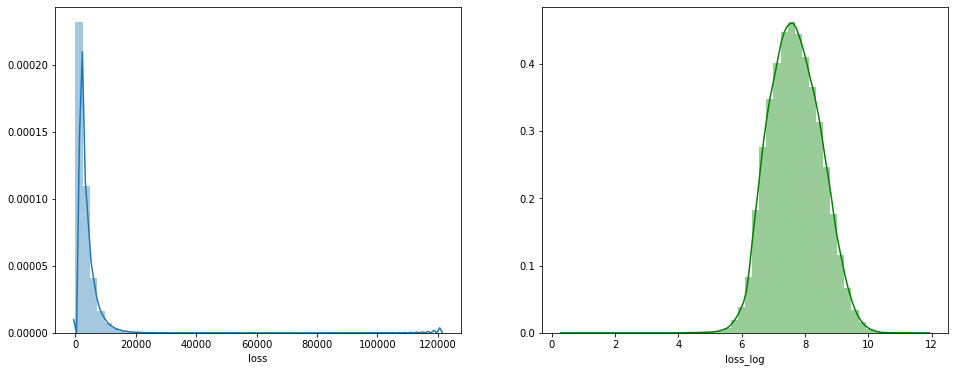

In [29]:
# loss가 좌편향되어 있어 log를 취함
X['loss_log'] = np.log1p(y)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(16, 6)
sns.distplot(y, ax=ax1)
sns.distplot(X.loss_log, ax=ax2, color="green")
plt.show()

In [46]:
round(pd.concat([X[cont_columns],train['loss'], train['loss_log']], axis=1).corr(),2).style.background_gradient(cmap='coolwarm')

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss,loss_log
cont1,1,-0.09,-0.45,0.37,-0.03,0.76,0.37,0.36,0.93,0.81,0.59,0.61,0.54,0.06,0,-0.01
cont2,-0.09,1,0.46,0.04,0.19,0.02,0.05,0.14,-0.03,0.06,0.12,0.11,0.02,-0.04,-0,0.1
cont3,-0.45,0.46,1,-0.34,0.09,-0.35,0.1,-0.19,-0.42,-0.33,0.03,0.01,-0.42,-0.04,-0,0.08
cont4,0.37,0.04,-0.34,1,0.16,0.22,-0.11,0.53,0.33,0.28,0.12,0.13,0.18,0.02,0,-0.03
cont5,-0.03,0.19,0.09,0.16,1,-0.15,-0.25,0.01,-0.09,-0.07,-0.15,-0.15,-0.08,-0.02,0,-0.01
cont6,0.76,0.02,-0.35,0.22,-0.15,1,0.66,0.44,0.8,0.88,0.77,0.78,0.82,0.04,0,0.03
cont7,0.37,0.05,0.1,-0.11,-0.25,0.66,1,0.14,0.38,0.49,0.75,0.74,0.29,0.02,0,0.08
cont8,0.36,0.14,-0.19,0.53,0.01,0.44,0.14,1,0.45,0.34,0.3,0.31,0.48,0.04,0,0.03
cont9,0.93,-0.03,-0.42,0.33,-0.09,0.8,0.38,0.45,1,0.79,0.61,0.63,0.64,0.08,0,0.02
cont10,0.81,0.06,-0.33,0.28,-0.07,0.88,0.49,0.34,0.79,1,0.7,0.71,0.71,0.04,0.01,0.01


In [30]:
X_test_model = pd.concat([X_cat_sqrt,X_cont], axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X_test_model, X['loss_log'], test_size=0.3, random_state=5)
lm = LinearRegression()
lm.fit(X_train,Y_train)
Y_pred_test = lm.predict(X_test)

print(f'Y변수=loss_log 의 R^2값: {r2_score(Y_test, Y_pred_test)}')
print('='*80)

X_train, X_test, Y_train, Y_test = train_test_split(X_test_model, y, test_size=0.3, random_state=5)
lm = LinearRegression()
lm.fit(X_train,Y_train)
Y_pred_test = lm.predict(X_test)

print(f'Y변수=loss 의 R^2값: {r2_score(Y_test, Y_pred_test)}')
print(f'Y변수=loss 의 MAE값: {metrics.mean_absolute_error(Y_test, Y_pred_test)}')

Y변수=loss_log 의 R^2값: 0.5092131471586976
Y변수=loss 의 R^2값: 0.5063243818888183
Y변수=loss 의 MAE값: 1310.9212109334944


# 데이터 전처리
- train.csv에서 7:3으로 train:validation으로 분류
- cat변수 -> catogory별 loss평균값을 PCA로 차원 축소
- cont변수 -> 선형회귀 모형의 종속변수 p-value값, VIF값을 통해 유의미한 변수만 별도 취합

In [108]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
X = train.iloc[:,1:-1]
y = train.loss

X_validation = test
# X, X_validation, y, y_validation = train_test_split(X, y, test_size=0.3, random_state=5)

In [140]:
# cout와 cat 변수명 리스트로 담기
cont_columns = []
cat_columns = []

for i in X.columns:
    if X[i].dtype == 'float':
        cont_columns.append(i)
    elif X[i].dtype == 'object':
        cat_columns.append(i)
        
# X, X_validation cont변수 설정
X_cont_tmp = X[cont_columns]
X_validation_cont_tmp = X_validation[cont_columns]

X_cont = X_cont_tmp.drop(columns=['cont3','cont5','cont1','cont11'])# cont변수는 3, 5, 1, 11만 삭제 후 그대로 사용
X_validation_cont = X_validation_cont_tmp.drop(columns=['cont3','cont5','cont1','cont11'])

# X, X_validation cat변수 설정
X_cat_tmp = X[cat_columns]
X_cat_tmp = X_cat_tmp.drop(columns=['cat15','cat22','cat70','cat88'])

X_validation_cat_tmp = X_validation[cat_columns]
X_validation_cat_tmp = X_validation_cat_tmp.drop(columns=['cat15','cat22','cat70','cat88'])

# cat변수 one-hot-encoding으로 변환
x_cat_dummy = pd.get_dummies(X_cat_tmp)
X_validation_cat_dummy = pd.get_dummies(X_validation_cat_tmp)

x_cat_col = x_cat_dummy.columns & X_validation_cat_dummy.columns

x_cat_dummy = x_cat_dummy[x_cat_col]
X_validation_cat_dummy = X_validation_cat_dummy[x_cat_col]

In [111]:
# cat변수 PCA로 차원축소
#X_cat_pca_tmp = X_cat_sqrt.drop(['loss'], axis=1)

pca_model = PCA(n_components=400)
X_cat_pca = pca_model.fit_transform(x_cat_dummy)
X_validation_cat_pca = pca_model.fit_transform(X_validation_cat_dummy)

In [143]:
# cat, cont변수 병합
# X_preData = pd.concat([pd.DataFrame(X_cat_pca),X_cont.reset_index(drop=True)], axis=1)
# X_validation_preData = pd.concat([pd.DataFrame(X_validation_cat_pca),X_validation_cont.reset_index(drop=True)], axis=1)

# cat, cont변수 병합
X_preData = pd.concat([x_cat_dummy,X_cont.reset_index(drop=True)], axis=1)
X_validation_preData = pd.concat([X_validation_cat_dummy,X_validation_cont.reset_index(drop=True)], axis=1)

In [5]:
# # 범주를 각 평균값으로 설정
# X_cat_tmp = pd.concat([X_cat_tmp, y], axis=1) # cat별 평균값을 구하기 위해 임시로 loss concat

# for cat in X_cat_tmp.drop(columns=['loss']).columns :
#     tmp_unique_len = len(X_cat_tmp[cat].unique())
#     for u_len in range(tmp_unique_len) :
#         tmp_mean = round(X_cat_tmp[X_cat_tmp[cat] == X_cat_tmp[cat].unique()[u_len]].loss.mean(),2)
#          # X_cat_tmp에 loss평균값 할당
#         X_cat_tmp[cat][X_cat_tmp[cat]==X_cat_tmp[cat].unique()[u_len]] = tmp_mean
#         # X_validationcat_tmp에 loss평균값 할당
#         try:
#             X_validation_cat_tmp[cat][X_validation_cat_tmp[cat]==X_validation_cat_tmp[cat].unique()[u_len]]= tmp_mean 
#         except :
#             pass
            
# X_cat_tmp = X_cat_tmp.drop(columns=['loss']) # loss삭제

# # 제곱근으로 변환
# # X_cat_sqrt = X_cat_tmp.drop(columns='loss').astype(int).apply(np.sqrt)

In [7]:
# # test에 없으나 train에 있는 관측치는 변수의 평균값으로 대체
# mean92 = round(X_validation_cat_tmp['cat92'].drop([85976,90190],axis=0).mean(),2)
# X_validation_cat_tmp['cat92'][X_validation_cat_tmp['cat92']==X_validation_cat_tmp['cat92'].unique()[7]] = mean92

# mean96 = round(X_validation_cat_tmp['cat96'].drop([120563],axis=0).mean(),2)
# X_validation_cat_tmp['cat96'][X_validation_cat_tmp['cat96']==X_validation_cat_tmp['cat96'].unique()[8]] = mean96

# mean99 = round(X_validation_cat_tmp['cat99'].drop([111817],axis=0).mean(),2)
# X_validation_cat_tmp['cat99'][X_validation_cat_tmp['cat99']==X_validation_cat_tmp['cat99'].unique()[16]] = mean99

# mean103 = round(X_validation_cat_tmp['cat103'].drop([28454],axis=0).mean(),2)
# X_validation_cat_tmp['cat103'][X_validation_cat_tmp['cat103']==X_validation_cat_tmp['cat103'].unique()[13]] =mean103

# mean106 = round(X_validation_cat_tmp['cat106'].drop([99038],axis=0).mean(),2)
# X_validation_cat_tmp['cat106'][X_validation_cat_tmp['cat106']==X_validation_cat_tmp['cat106'].unique()[17]] =mean106

In [163]:
# for i in X_validation_cat_tmp.columns :
#     print(f'X_test: {i} : {X_cat_tmp[i].unique()}')
#     print(f'X_validation: {i} : {X_validation_cat_tmp[i].unique()}')
#     print('='*50)

In [9]:
# # X, X_validation scale화
# X_cat_scale = scale(X_cat_tmp)
# X_validation_cat_scale = scale(X_validation_cat_tmp)
# print(X_cat_scale.shape)
# print(X_validation_cat_scale.shape)

(188318, 112)
(125546, 112)


In [12]:
# # cat변수 PCA로 차원축소
# #X_cat_pca_tmp = X_cat_sqrt.drop(['loss'], axis=1)

# pca_model = PCA(n_components=50) # pca 차원이 본래 변수의 90%의 설명력을 가지는 수준 
# X_cat_pca = pca_model.fit_transform(X_cat_tmp)
# X_validation_cat_pca = pca_model.fit_transform(X_validation_cat_tmp)

# 딥러닝 모델

In [82]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, RMSprop, SGD

In [154]:
n_vars = X_preData.shape[1]

my_model = Sequential()
my_model.add(Dense(input_dim = n_vars, units=800, activation="relu"))
# my_model.add(Dropout(0.2))
my_model.add(Dense(units = 500, activation='relu'))
# my_model.add(Dropout(0.2))
my_model.add(Dense(units = 200, activation='relu'))
# my_model.add(Dropout(0.2))
my_model.add(Dense(units = 100, activation='relu'))
# my_model.add(Dropout(0.2))
my_model.add(Dense(units = 50, activation='relu'))
# my_model.add(Dropout(0.2))
my_model.add(Dense(units=1, activation='linear'))

In [155]:
my_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 800)               852800    
_________________________________________________________________
dense_44 (Dense)             (None, 500)               400500    
_________________________________________________________________
dense_45 (Dense)             (None, 200)               100200    
_________________________________________________________________
dense_46 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_47 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_48 (Dense)             (None, 1)                 51        
Total params: 1,378,701
Trainable params: 1,378,701
Non-trainable params: 0
_________________________________________________________________


In [156]:
n_epochs = 15
n_batch_size = 100
learn_rate = 0.005

In [157]:
# 최적화 방법 정하고 컴파일.
my_optimizer=Adam(lr=learn_rate)
my_model.compile(loss = "mae", optimizer = my_optimizer, metrics=["mae"])

In [158]:
my_summary = my_model.fit(X_preData, y, epochs=n_epochs, batch_size = n_batch_size, validation_split = 0.2, verbose = True)

Train on 150654 samples, validate on 37664 samples
Epoch 1/15
150654/150654 [==============================] - 15s 98us/step - loss: 1255.1689 - mean_absolute_error: 1255.1689 - val_loss: 1201.0097 - val_mean_absolute_error: 1201.0097
Epoch 2/15
150654/150654 [==============================] - 14s 91us/step - loss: 1197.6943 - mean_absolute_error: 1197.6943 - val_loss: 1217.9697 - val_mean_absolute_error: 1217.9697
Epoch 3/15
150654/150654 [==============================] - 14s 92us/step - loss: 1181.7955 - mean_absolute_error: 1181.7955 - val_loss: 1165.9592 - val_mean_absolute_error: 1165.9592
Epoch 4/15
150654/150654 [==============================] - 14s 91us/step - loss: 1169.5816 - mean_absolute_error: 1169.5816 - val_loss: 1160.7166 - val_mean_absolute_error: 1160.7166
Epoch 5/15
150654/150654 [==============================] - 14s 90us/step - loss: 1155.5059 - mean_absolute_error: 1155.5059 - val_loss: 1163.1060 - val_mean_absolute_error: 1163.1060
Epoch 6/15
150654/150654 [===

In [159]:
my_summary.history.keys()

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])

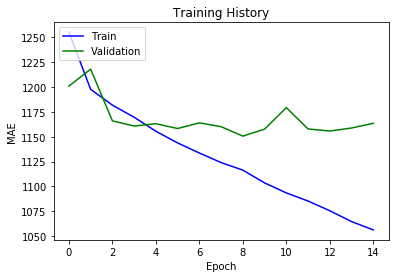

In [160]:
plt.plot(my_summary.history['mean_absolute_error'], c="b")
plt.plot(my_summary.history['val_mean_absolute_error'], c="g")
plt.title('Training History')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## 예측 및 결과 평가 (test MAE 계산)

In [161]:
# 직접 예측하여 평가한다.
y_pred = my_model.predict(X_validation_preData)[:,0]
# y_pred = y_pred.reshape(-1,1)
# MAE = metrics.mean_absolute_error(y_validation, y_pred)
# np.round(MAE,3)

In [162]:
pd.DataFrame(y_pred).to_csv('allstate_pred.csv')